Modelo Acople SWMM-MODLFOW Llanquihue

# Import library dependencies

In [217]:
import pandas as pd
import numpy as np
from numpy import *
from scipy.spatial import cKDTree
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource
import os
import platform
import sys
import math
import time
import re
from datetime import datetime

from pyswmm import Simulation, Nodes, Subcatchments, Links, SystemStats, RainGages

import flopy
from flopy.discretization.structuredgrid import StructuredGrid
from flopy.utils import Raster

import geopandas as gpd
from geopandas.tools import sjoin
from geopandas import GeoDataFrame
from shapely.geometry import Point, Polygon
from shapely.geometry import Point
import fiona

import rasterio
from rasterio.plot import show
from rasterio.merge import merge
from rasterio.plot import show_hist

from affine import Affine
from pyproj import Proj, transform
import folium
from folium import plugins
from folium import IFrame
import cartopy as cp
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
import cartopy.io.img_tiles as cimgt

%matplotlib inline

os.environ['KMP_DUPLICATE_LIB_OK']='True'

print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))
#print('pyswmm version: {}'.format(pyswmm.__version__))
print('rasterio version: {}'.format(rasterio.__version__))
print('geopandas version: {}'.format(gpd.__version__))
print('cartopy version: {}'.format(cp.__version__))

3.7.8 | packaged by conda-forge | (default, Jul 31 2020, 01:53:57) [MSC v.1916 64 bit (AMD64)]
numpy version: 1.19.2
matplotlib version: 3.3.2
flopy version: 3.3.0
rasterio version: 1.1.2
geopandas version: 0.8.1
cartopy version: 0.17.0


# Study Area

In [218]:
# llanquihue_coordinates=[-41.25,-73.] 
# m = folium.Map(location=llanquihue_coordinates, zoom_start=14, control_scale=True)
# m

# MODFLOW model

## Create MODFLOW Workspace

In [219]:
modelname='LLANQUIHUE'
if platform.system() == 'Windows': exe_name='mfnwt.exe'
if platform.system() == 'Darwin': exe_name='mfnwt'

workspace = 'LLANQUIHUE_MF_workspace'
if not os.path.isdir(workspace):
    os.mkdir(workspace)
    
ml = flopy.modflow.Modflow(modelname, version='mfnwt', exe_name=exe_name, model_ws=workspace)

## DIS Package

### Spatial Discretization: Finite Grid

We are creating a square model with number of layers (`nlay`), number of rows and columns (`nrows`, `ncols`), the lenghts of the sides of the model (`W`, `H`), aquifer thickness (`d`)

Model domain: 5 x 5 km

In [220]:
nlay = 1     #number of layers
nrows = 100  #number of rows
ncols = 100  #number of columns
W = 5000     #model size (X)
H = 5000     #model size (Y)
d = 50      #aquifer thickness
top = 0
bottom = -50

x_resolution = W/ncols    
y_resolution = H/nrows

delr = y_resolution
delc = x_resolution

print('model resolution: x=%sm, y=%sm' % (x_resolution,y_resolution))

model resolution: x=50.0m, y=50.0m


### Temporal Discrtization: Steady Flow as Initial Condition

In [221]:
nper = 1
perlen = 1
nstp = 1
steady = True

### Create DIS package

In [222]:
dis = flopy.modflow.ModflowDis(
    ml, nlay=nlay, nrow=nrows, ncol=ncols,
    delr=delr, delc=delc, top=top, botm=bottom,
    nper=nper, perlen=perlen, nstp=nstp, steady=steady)

### Set spatial reference and ground elevation

- Set spatial reference: offsets refer to lower left corner of the model

In [223]:
ml.modelgrid.set_coord_info(xoff=663776, yoff=5428040, angrot=0, epsg=32718)

In [224]:
ml.update_modelgrid()

- Plot Grid

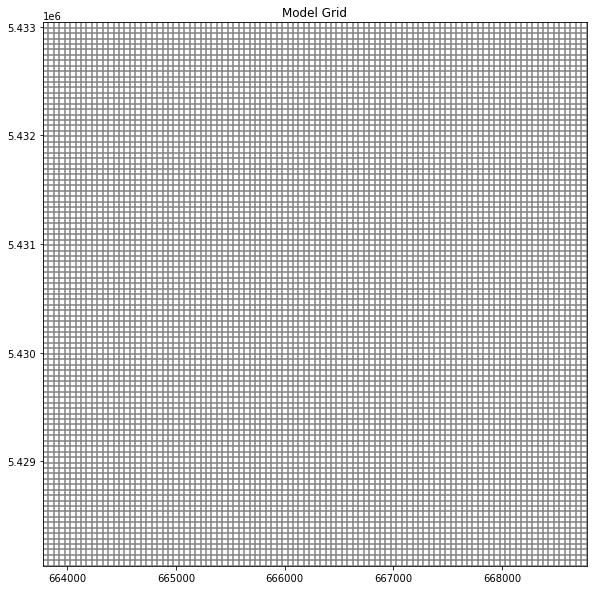

In [225]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

mapview = flopy.plot.PlotMapView(model=ml)

linecollection = mapview.plot_grid()

t = ax.set_title("Model Grid")

- Save model grid as .shp (verify in QGIS). 

In [226]:
ml.modelgrid.write_shapefile('GIS/SHAPES/MODFLOW_grid_flopy.shp')

wrote GIS/SHAPES/MODFLOW_grid_flopy.shp


- Load using geopandas for further processing.

In [227]:
MODFLOW_gdf=gpd.read_file('GIS/SHAPES/MODFLOW_grid_flopy.shp')

In [228]:
MODFLOW_gdf.crs

<Projected CRS: EPSG:32718>
Name: WGS 84 / UTM zone 18S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World - S hemisphere - 78°W to 72°W - by country
- bounds: (-78.0, -80.0, -72.0, 0.0)
Coordinate Operation:
- name: UTM zone 18S
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

- Apply Ground Elevation to model TOP: Intersect with DEM Raster (Corrected by CIREN)

In [229]:
dem = rasterio.open('GIS/DEM/DEM_studyzone_CIREN.tif')

In [230]:
dem.crs

CRS.from_epsg(32718)

- Plot DEM

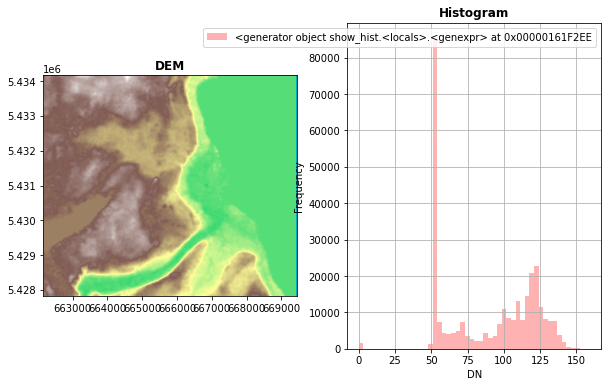

In [231]:
fig = plt.figure(figsize=(10, 6))

ax1=fig.add_subplot(121)
ax2=fig.add_subplot(122)

show(dem,title='DEM', cmap='terrain',ax=ax1)
show_hist(dem, bins=50, lw=0.0, stacked=False, alpha=0.3,histtype='stepfilled', title="Histogram", ax=ax2)

- Apply Ground Elevation

In [232]:
DEMraster_path='../GIS/DEM/clipped_dem.tif'

def DEMraster_to_MODFLOW(DEMraster_path,MODFLOW_gdf):
    
    r=rasterio.open(DEMraster_path)
    T0 = r.transform                  # upper-left pixel corner affine transform
    z = r.read(1)                     # get the elevation values

    # All rows and columns
    cols, rows = np.meshgrid(np.arange(z.shape[1]), np.arange(z.shape[0]))

    # Get affine transform for pixel centres
    T1 = T0 * Affine.translation(0.5, 0.5)

    # Function to convert pixel row/column index (from 0) to easting/northing at centre
    rc2en = lambda r, c: (c, r) * T1

    # All eastings and northings (there is probably a faster way to do this)
    eastings, northings = np.vectorize(rc2en, otypes=[np.float, np.float])(rows, cols)

    # Set CRS of MODFLOW grid GeoPandas DataFrame
    MODFLOW_gdf.crs={'init': 'epsg:32718'}

    # Flatten all the datasets
    df=pd.DataFrame({
    'eastings': eastings.flatten().T,
    'northings': northings.flatten().T,
    'pix_row': rows.flatten().T,
    'pix_col': cols.flatten().T,
    'elevation': z.flatten().T,
    })

    # Create a GeoPandas DataFrame for the raster pixels from the flattened arrays
    geometry = [Point(xy) for xy in zip(df.eastings, df.northings)]
    df = df.drop(['eastings', 'northings'], axis=1)
    crs = {'init': 'epsg:32718'}
    geo_df = GeoDataFrame(df, crs=crs, geometry=geometry)

    # Do a spatial join between the raster and the MODFLOW GeoDataframes

    joined=gpd.sjoin(geo_df, MODFLOW_gdf, how="right", op='within')

    # We just need to know the value that was applied to each MODFLOW cell
    modflow_cell_list=joined.index.unique()
    
    row_array=[]
    column_array=[]
    elevation_array=[]
    MFcellindex_array=[]

    for modflow_cell in modflow_cell_list:
        df_temp=joined.loc[joined.index==modflow_cell]
        MFcellindex_array.append(modflow_cell)
        row_array.append(df_temp['row'].max())
        column_array.append(df_temp['column'].max())
        elevation_array.append(df_temp['elevation'].mean())

    df_out=pd.DataFrame({
        'MFcellindex': MFcellindex_array,
        'row': row_array,
        'column': column_array,
        'elevation': elevation_array,
        })    

    df_out=df_out.set_index(['MFcellindex'])

    # Merge back the data to the original MODFLOW gpd

    MODFLOW_gdf_appended_ELEV=MODFLOW_gdf.merge(df_out)

    # rows and columns come up as floats, change to int
    MODFLOW_gdf_appended_ELEV.row=MODFLOW_gdf_appended_ELEV.row.astype(int)
    MODFLOW_gdf_appended_ELEV.column=MODFLOW_gdf_appended_ELEV.column.astype(int)

    return MODFLOW_gdf_appended_ELEV

In [233]:
DEMraster_path='GIS/DEM/DEM_studyzone_CIREN.tif'

In [234]:
MODFLOW_gdf=DEMraster_to_MODFLOW(DEMraster_path,MODFLOW_gdf)

C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: Right multiplication will be prohibited in version 3.0
  app.launch_new_instance()
C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [235]:
MODFLOW_gdf

,node,row,column,geometry,elevation
0,1,1,1,"POLYGON ((663776.000 5433040.000, 663826.000 5...",118.4375
1,2,1,2,"POLYGON ((663826.000 5433040.000, 663876.000 5...",120.5000
2,3,1,3,"POLYGON ((663876.000 5433040.000, 663926.000 5...",120.4375
3,4,1,4,"POLYGON ((663926.000 5433040.000, 663976.000 5...",118.9375
4,5,1,5,"POLYGON ((663976.000 5433040.000, 664026.000 5...",117.1875
...,...,...,...,...,...
9995,9996,100,96,"POLYGON ((668526.000 5428090.000, 668576.000 5...",80.3750
9996,9997,100,97,"POLYGON ((668576.000 5428090.000, 668626.000 5...",70.0625
9997,9998,100,98,"POLYGON ((668626.000 5428090.000, 668676.000 5...",64.1250
9998,9999,100,99,"POLYGON ((668676.000 5428090.000, 668726.000 5...",64.5000


- Create Top array using MODFLOW_gdf

In [236]:
L1_top = np.ones((nrows,ncols)) 

for index, row in MODFLOW_gdf.iterrows():
    L1_top[row['row']-1,row['column']-1] = row['elevation']

- Actualize DIS package

In [237]:
dis = flopy.modflow.ModflowDis(
    ml, nlay=nlay, nrow=nrows, ncol=ncols,
    delr=delr, delc=delc, top=L1_top, botm=bottom,
    nper=nper, perlen=perlen, nstp=nstp, steady=steady)

****Warning -- two packages of the same type:  <class 'flopy.modflow.mfdis.ModflowDis'> <class 'flopy.modflow.mfdis.ModflowDis'>
replacing existing Package...


- plot DIS package 

[<AxesSubplot:title={'center':' model_top'}>,
 <AxesSubplot:title={'center':'botm layer 1'}>,
 <AxesSubplot:title={'center':'thickness layer 1'}>]

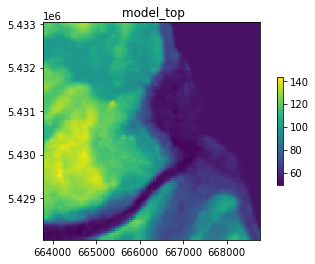

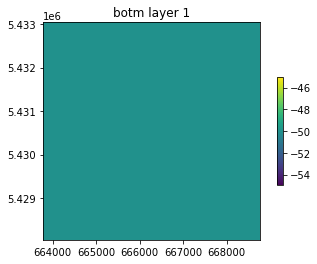

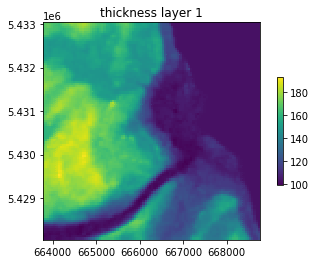

In [238]:
dis.plot()

## BAS Package

- Import Shapefiles that define boundry condictions

In [239]:
lakeBC_gdf=gpd.read_file('GIS/SHAPES/lake.shp')

In [240]:
riverBC_gdf=gpd.read_file('GIS/SHAPES/rio_maullin.shp')

(<AxesSubplot:>, <AxesSubplot:>)

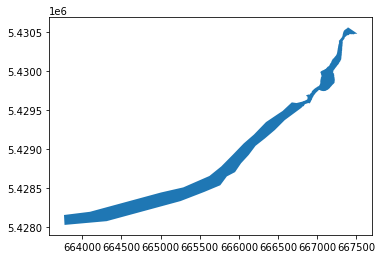

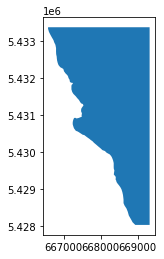

In [241]:
riverBC_gdf.plot(), lakeBC_gdf.plot()

In [242]:
inactive_BC_gdf=gpd.read_file('GIS/SHAPES/inactive_cells.shp')

<AxesSubplot:>

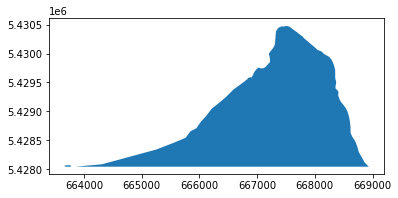

In [243]:
inactive_BC_gdf.plot()

In [244]:
MODFLOW_gdf['ibound']=1

- Map boundry conditions with spatial joins

In [245]:
poly_MODFLOWgrid_gdf = gpd.GeoDataFrame.from_file('GIS/SHAPES/MODFLOW_grid_flopy.shp')

poly_inactiveBC_gdf=gpd.GeoDataFrame.from_file('GIS/SHAPES/inactive_cells.shp')
poly_riverBC_gdf=gpd.GeoDataFrame.from_file('GIS/SHAPES/lake.shp')
poly_lakeBC_gdf=gpd.GeoDataFrame.from_file('GIS/SHAPES/rio_maullin.shp')

contained_inactivedBC_gdf=gpd.sjoin(poly_MODFLOWgrid_gdf, poly_inactiveBC_gdf, how="inner", op='intersects')
contained_riverBC_gdf=gpd.sjoin(poly_MODFLOWgrid_gdf, poly_riverBC_gdf, how="inner", op='intersects')
contained_lakeBC_gdf=gpd.sjoin(poly_MODFLOWgrid_gdf,poly_lakeBC_gdf, how="inner", op='intersects')

MODFLOW_gdf['inactive']=MODFLOW_gdf.index.isin(contained_inactivedBC_gdf.index.values.tolist())
MODFLOW_gdf['river']=MODFLOW_gdf.index.isin(contained_riverBC_gdf.index.values.tolist())
MODFLOW_gdf['lake']=MODFLOW_gdf.index.isin(contained_lakeBC_gdf.index.values.tolist())

- Set ibounds for each boundary condition (e.g., active=1, fixed-head=-1, inactive=0)    

In [246]:
MODFLOW_gdf.loc[MODFLOW_gdf.inactive == True, 'ibound'] = 0
MODFLOW_gdf.loc[MODFLOW_gdf.river == True, 'ibound'] = -1
MODFLOW_gdf.loc[MODFLOW_gdf.lake == True, 'ibound'] = -1

<AxesSubplot:>

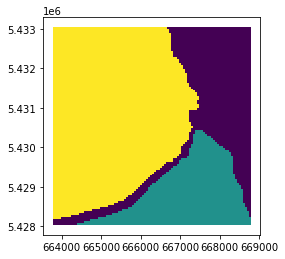

In [247]:
MODFLOW_gdf.plot(column="ibound")

In [248]:
MODFLOW_gdf[['row', 'column']] = MODFLOW_gdf[['row', 'column']].astype(int)

In [249]:
ibound = np.ones((nlay,nrows,ncols)) 

for index, row in MODFLOW_gdf.iterrows():
    ibound[:,row['row']-1,row['column']-1] = row['ibound']

### Create BAS package

In [250]:
bas = flopy.modflow.ModflowBas(ml, ibound=ibound, strt=L1_top)

[<AxesSubplot:title={'center':'ibound layer 1'}>,
 <AxesSubplot:title={'center':'strt layer 1'}>]

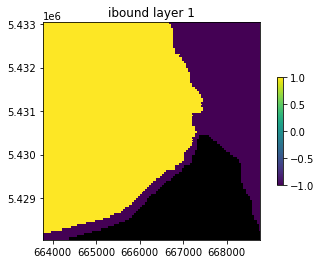

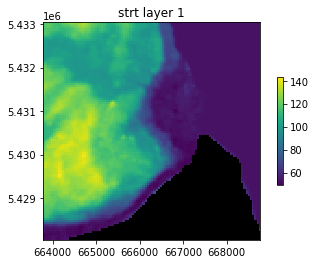

In [251]:
bas.plot()

## UPW Package

- Define Hydraulic Properties

In [252]:
# corresponde a marga limosa (m/s), chequear por referencias Sy

In [253]:
upw = flopy.modflow.ModflowUpw(ml, hk=0.156, sy=0.25, laytyp=1, iphdry=0, ipakcb=53)

## DRN Package

- All perv cells can drain: use SWMM subcatchments and % imperv to determine cells that can drain with an aleatory distribution

- Import SWMM subcatchment shapefile

In [254]:
SWMM_S_gdf=gpd.read_file('GIS/SHAPES/SWMM_S.shp')

In [255]:
SWMM_S_gdf

,ID,AREA,SWMM_NAME,geometry
0,23,26031,S23,"POLYGON ((666724.701 5431105.774, 666739.853 5..."
1,21,5949,S21,"POLYGON ((666649.467 5431111.906, 666645.885 5..."
2,22,16014,S22,"POLYGON ((666547.581 5431057.353, 666645.885 5..."
3,37,21507,S37,"POLYGON ((666547.543 5431057.474, 666541.444 5..."
4,20,8504,S20,"POLYGON ((666417.585 5431134.363, 666550.073 5..."
5,9,14329,S9,"POLYGON ((666678.482 5431480.744, 666681.250 5..."
6,12,28246,S12,"POLYGON ((666533.454 5431122.050, 666417.548 5..."
7,13,23201,S13,"POLYGON ((666638.528 5431382.537, 666657.806 5..."
8,19,14893,S19,"POLYGON ((666417.088 5431134.681, 666410.296 5..."
9,28,18390,S28,"POLYGON ((666833.497 5430876.274, 666731.153 5..."


In [256]:
SWMM_SE_gdf=gpd.read_file('GIS/SHAPES/SWMM_SE.shp')
SWMM_SE_gdf["%imperv"]=0.1

In [257]:
SWMM_SE_gdf

,id,AREA,SWMM_NAME,geometry,%imperv
0,42,473078,E1,"POLYGON ((666384.543 5430306.734, 666477.182 5...",0.1
1,43,1598979,E2,"POLYGON ((665859.768 5430895.760, 665987.852 5...",0.1
2,44,184416,E3,"POLYGON ((666283.010 5430805.665, 666280.309 5...",0.1
3,45,179470,E4,"POLYGON ((666665.315 5430479.431, 666690.749 5...",0.1
4,46,94306,E5,"POLYGON ((666250.448 5431211.651, 666249.473 5...",0.1
5,47,845454,E6,"POLYGON ((666080.973 5431330.203, 666063.137 5...",0.1


- Import xlsx with % imperviuos for each subcatchment

In [258]:
imperv_S=pd.read_excel("S_imperv.xlsx")

C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\xlrd\xlsx.py:266: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\xlrd\xlsx.py:312: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\xlrd\xlsx.py:266: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():


In [259]:
SWMM_S_gdf=SWMM_S_gdf.merge(imperv_S, left_on='SWMM_NAME', right_on='NAME')

In [260]:
SWMM_S_gdf=SWMM_S_gdf.drop(columns=["NAME"])
SWMM_S_gdf=SWMM_S_gdf.rename(columns={"ID": "id"})

In [261]:
SWMM_S_gdf=SWMM_S_gdf.append(SWMM_SE_gdf)

In [262]:
SWMM_S_gdf

,id,AREA,SWMM_NAME,geometry,%imperv
0,23,26031,S23,"POLYGON ((666724.701 5431105.774, 666739.853 5...",0.814940
1,21,5949,S21,"POLYGON ((666649.467 5431111.906, 666645.885 5...",0.814964
2,22,16014,S22,"POLYGON ((666547.581 5431057.353, 666645.885 5...",0.814964
3,37,21507,S37,"POLYGON ((666547.543 5431057.474, 666541.444 5...",0.814964
4,20,8504,S20,"POLYGON ((666417.585 5431134.363, 666550.073 5...",0.814964
5,9,14329,S9,"POLYGON ((666678.482 5431480.744, 666681.250 5...",0.770011
6,12,28246,S12,"POLYGON ((666533.454 5431122.050, 666417.548 5...",0.814729
7,13,23201,S13,"POLYGON ((666638.528 5431382.537, 666657.806 5...",0.752181
8,19,14893,S19,"POLYGON ((666417.088 5431134.681, 666410.296 5...",0.783926
9,28,18390,S28,"POLYGON ((666833.497 5430876.274, 666731.153 5...",0.767155


For de spatial joins is better to use cells centroid to avoid duplicate

In [263]:
MODFLOW_centroid=gpd.GeoDataFrame()
MODFLOW_centroid["geometry"]=MODFLOW_gdf["geometry"].centroid
MODFLOW_centroid["node"]=MODFLOW_gdf["node"]
MODFLOW_centroid.crs = {'init': 'epsg:32718'}

C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


- Saptial join with SWMM subcatchments

<AxesSubplot:>

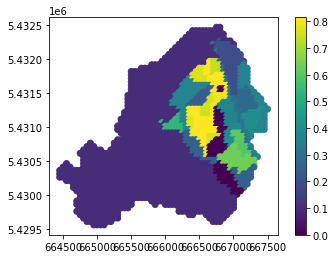

In [264]:
map_S_to_MFgrid_gdf=gpd.sjoin(MODFLOW_centroid, SWMM_S_gdf, how="left", op='intersects')
map_S_to_MFgrid_gdf.plot(column="%imperv", legend=True)

In [265]:
MODFLOW_gdf_SWMM=pd.DataFrame()
MODFLOW_gdf_SWMM=MODFLOW_gdf.join(map_S_to_MFgrid_gdf,rsuffix='_right')

In [266]:
MODFLOW_gdf_SWMM

,node,row,column,geometry,elevation,ibound,inactive,river,lake,geometry_right,node_right,index_right,id,AREA,SWMM_NAME,%imperv
0,1,1,1,"POLYGON ((663776.000 5433040.000, 663826.000 5...",118.4375,1,False,False,False,POINT (663801.000 5433015.000),1,NaN,NaN,NaN,NaN,NaN
1,2,1,2,"POLYGON ((663826.000 5433040.000, 663876.000 5...",120.5000,1,False,False,False,POINT (663851.000 5433015.000),2,NaN,NaN,NaN,NaN,NaN
2,3,1,3,"POLYGON ((663876.000 5433040.000, 663926.000 5...",120.4375,1,False,False,False,POINT (663901.000 5433015.000),3,NaN,NaN,NaN,NaN,NaN
3,4,1,4,"POLYGON ((663926.000 5433040.000, 663976.000 5...",118.9375,1,False,False,False,POINT (663951.000 5433015.000),4,NaN,NaN,NaN,NaN,NaN
4,5,1,5,"POLYGON ((663976.000 5433040.000, 664026.000 5...",117.1875,1,False,False,False,POINT (664001.000 5433015.000),5,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,100,96,"POLYGON ((668526.000 5428090.000, 668576.000 5...",80.3750,0,True,False,False,POINT (668551.000 5428065.000),9996,NaN,NaN,NaN,NaN,NaN
9996,9997,100,97,"POLYGON ((668576.000 5428090.000, 668626.000 5...",70.0625,0,True,False,False,POINT (668601.000 5428065.000),9997,NaN,NaN,NaN,NaN,NaN
9997,9998,100,98,"POLYGON ((668626.000 5428090.000, 668676.000 5...",64.1250,0,True,False,False,POINT (668651.000 5428065.000),9998,NaN,NaN,NaN,NaN,NaN
9998,9999,100,99,"POLYGON ((668676.000 5428090.000, 668726.000 5...",64.5000,0,True,False,False,POINT (668701.000 5428065.000),9999,NaN,NaN,NaN,NaN,NaN


In [267]:
MODFLOW_gdf_SWMM=MODFLOW_gdf_SWMM.drop(columns=["geometry_right","node_right", "index_right", "AREA"])
MODFLOW_gdf_SWMM=MODFLOW_gdf_SWMM.rename(columns={"SWMM_NAME": "S"})

<AxesSubplot:>

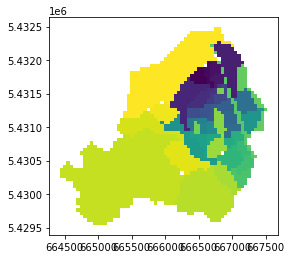

In [268]:
MODFLOW_gdf_SWMM.plot(column="id")

In [269]:
MODFLOW_gdf_SWMM.groupby("id").count()

,node,row,column,geometry,elevation,ibound,inactive,river,lake,S,%imperv
id,,,,,,,,,,,
1.0,18,18,18,18,18,18,18,18,18,18,18
2.0,12,12,12,12,12,12,12,12,12,12,12
3.0,12,12,12,12,12,12,12,12,12,12,12
4.0,11,11,11,11,11,11,11,11,11,11,11
5.0,71,71,71,71,71,71,71,71,71,71,71
6.0,66,66,66,66,66,66,66,66,66,66,66
7.0,23,23,23,23,23,23,23,23,23,23,23
8.0,4,4,4,4,4,4,4,4,4,4,4
9.0,5,5,5,5,5,5,5,5,5,5,5


In [270]:
MODFLOW_gdf_SWMM["DRN"]=1

In [271]:
MODFLOW_gdf_SWMM.loc[MODFLOW_gdf_SWMM["%imperv"] > 0.5, 'DRN'] = 0

<AxesSubplot:>

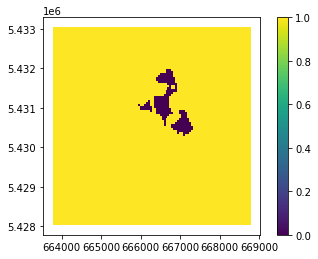

In [272]:
MODFLOW_gdf_SWMM.plot(column="DRN", legend=True)

In [273]:
is_drn = MODFLOW_gdf_SWMM[MODFLOW_gdf_SWMM['DRN'] == 1]

In [274]:
is_drn

,node,row,column,geometry,elevation,ibound,inactive,river,lake,id,S,%imperv,DRN
0,1,1,1,"POLYGON ((663776.000 5433040.000, 663826.000 5...",118.4375,1,False,False,False,NaN,NaN,NaN,1
1,2,1,2,"POLYGON ((663826.000 5433040.000, 663876.000 5...",120.5000,1,False,False,False,NaN,NaN,NaN,1
2,3,1,3,"POLYGON ((663876.000 5433040.000, 663926.000 5...",120.4375,1,False,False,False,NaN,NaN,NaN,1
3,4,1,4,"POLYGON ((663926.000 5433040.000, 663976.000 5...",118.9375,1,False,False,False,NaN,NaN,NaN,1
4,5,1,5,"POLYGON ((663976.000 5433040.000, 664026.000 5...",117.1875,1,False,False,False,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,100,96,"POLYGON ((668526.000 5428090.000, 668576.000 5...",80.3750,0,True,False,False,NaN,NaN,NaN,1
9996,9997,100,97,"POLYGON ((668576.000 5428090.000, 668626.000 5...",70.0625,0,True,False,False,NaN,NaN,NaN,1
9997,9998,100,98,"POLYGON ((668626.000 5428090.000, 668676.000 5...",64.1250,0,True,False,False,NaN,NaN,NaN,1
9998,9999,100,99,"POLYGON ((668676.000 5428090.000, 668726.000 5...",64.5000,0,True,False,False,NaN,NaN,NaN,1


In [275]:
# Burn drains 0.5 m into the DEM
DRN_burn_depth=0.0

# Global parameters needed to calculate drain conductance (see reference MODELMUSE DRN package pane)
DRN_L = x_resolution 
DRN_W = y_resolution
DRN_M = 1
DRN_K = 0.1 #m/dia      

DRN_C=DRN_K*DRN_L*DRN_W/DRN_M


DRN_stress_period_data=[]

for index,row in is_drn.iterrows():
    new_row=[0,row["row"]-1,row["column"]-1,row["elevation"]-DRN_burn_depth,DRN_C]
    DRN_stress_period_data.append(new_row)

### Create DRN package

In [276]:
drn = flopy.modflow.ModflowDrn(ml, stress_period_data=DRN_stress_period_data, ipakcb=53)

[<AxesSubplot:title={'center':' DRN location stress period 1 layer 1'}>]

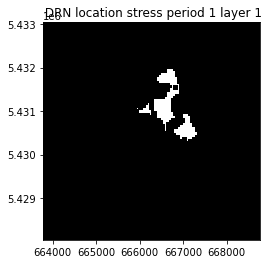

In [277]:
drn.plot()

## RCH package

- For steady flow rch=P_anual-EVT:

In [278]:
rch = flopy.modflow.ModflowRch(ml, nrchop=3, rech=0.002)

## EVT package

## OC package

In [279]:
spd = {(0,0): ['save head', 'save budget'], (1,0): ['save head', 'save budget']}
oc = flopy.modflow.ModflowOc(ml, stress_period_data=spd) 

## NWT package

In [280]:
nwt = flopy.modflow.ModflowNwt(ml)

## Checks, run steady model, read outputs, plots

In [281]:
ml.get_package_list()

['DIS', 'BAS6', 'UPW', 'DRN', 'RCH', 'OC', 'NWT']

In [282]:
ml.check()


LLANQUIHUE MODEL DATA VALIDATION SUMMARY:
  1886 Warnings:
    DRN package: BC in inactive cell
    OC package: action(s) defined in OC stress_period_data ignored as they are not part the stress periods defined by DIS

  Checks that passed:
    Compatible solver package
    Unit number conflicts
    DIS package: zero or negative thickness
    DIS package: thin cells (less than checker threshold of 1.0)
    DIS package: nan values in top array
    DIS package: nan values in bottom array
    BAS6 package: isolated cells in ibound array
    BAS6 package: Not a number
    UPW package: zero or negative horizontal hydraulic conductivity values
    UPW package: zero or negative vertical hydraulic conductivity values
    UPW package: negative horizontal anisotropy values
    UPW package: horizontal hydraulic conductivity values below checker threshold of 1e-11
    UPW package: horizontal hydraulic conductivity values above checker threshold of 100000.0
    UPW package: vertical hydraulic cond

In [283]:
ml.write_input()
ml.run_model()

FloPy is using the following  executable to run the model: .\mfnwt.exe

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.1.4 4/01/2018                         
                    BASED ON MODFLOW-2005 Version 1.12.0 02/03/2017                       

                    SWR1 Version 1.04.0 09/15/2016                       

 Using NAME file: LLANQUIHUE.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2020/11/05 16:11:28

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2020/11/05 16:11:28
 Elapsed run time:  0.305 Seconds

  Normal termination of simulation


(True, [])

## Read heads file for Steady Flow: Initial Condition for unsteady

In [284]:
fname = os.path.join('LLANQUIHUE_MF_workspace', 'LLANQUIHUE.hds')
headfile = flopy.utils.HeadFile(fname, model=ml)
heads = headfile.get_data()
heads[heads==1.e+30] = np.nan            # fix masked data 
heads[heads==-999.99] = np.nan 

In [285]:
np.nanmin(heads[0]), np.nanmax(heads[0])

(48.875, 129.6524)

In [286]:
strt = heads[0]

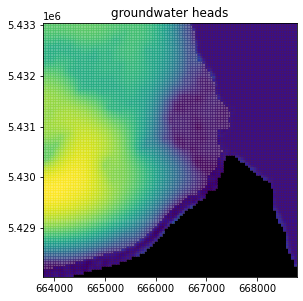

In [287]:
fig = plt.figure(figsize=(10, 10))

levels = np.arange(0, 150, 1)

ax = fig.add_subplot(1, 2, 1, aspect='equal')
ax.set_title('groundwater heads')
mapview = flopy.plot.PlotMapView(model=ml)
quadmesh = mapview.plot_ibound()
quadmesh = mapview.plot_array(heads, masked_values=[999.], alpha=0.5)

# LOAD SWMM Model

In [288]:
dire="SWMM_Llanquihue"
file="/Llanquihue.inp"
SWMM_path=dire + "/" + file

In [289]:
with Simulation(SWMM_path) as sim:
    if not sim.flow_units=="CMS":
        print("SWMM flow units must be CMS")

## SWMM Elements:

In [290]:
SWMM_names_df=pd.DataFrame()

In [291]:
SWMM_names_df=pd.read_excel("SWMM_elem_names.xlsx")

C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\xlrd\xlsx.py:266: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\xlrd\xlsx.py:312: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\xlrd\xlsx.py:266: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():


In [292]:
#SWMM Subcatchments names:
S_names_list=SWMM_names_df["S_names"].dropna(how=all).astype(str).values.tolist()
#SWMM Wetlands Storge Unites names:
WSU_names_list=SWMM_names_df["WSU_names"].dropna(how=all).astype(str).values.tolist()
#Wetlands subcatchments
SW_names_list=SWMM_names_df["SW_names"].dropna(how=all).astype(str).values.tolist()
#SWMM Nodes names:
J_names_list=SWMM_names_df["J_names"].dropna(how=all).astype(str).values.tolist()
#SWMM conduits names:
C_names_list=SWMM_names_df["C_names"].dropna(how=all).astype(str).values.tolist()
#SWMM weirs names:
V_names_list=SWMM_names_df["V_names"].dropna(how=all).astype(str).values.tolist()
#SWMM SU names:
FSU_names_list=SWMM_names_df["FSU_names"].dropna(how=all).astype(str).values.tolist()
#Rain gages for wetlands subcathments
#RG_SU_names_list=names_df["RG_SU_names_list"].dropna(how=all).astype(str).values.tolist()

In [293]:
with Simulation(SWMM_path) as sim:
    S_list=[]
    WSU_list=[]
    FSU_list=[]
    J_list=[]
    C_list=[]
    SW_list=[]
    V_list=[]
    S_areas=[]
    for s in S_names_list:
        S_list.append(Subcatchments(sim)[s])
        S_areas.append(Subcatchments(sim)[s].area) #[ha]  
    for i in range(len(WSU_names_list)):
        WSU_list.append(Nodes(sim)[WSU_names_list[i]])
    for i in range(len(FSU_names_list)):
        FSU_list.append(Nodes(sim)[FSU_names_list[i]])
    for j in J_names_list:
        J_list.append(Nodes(sim)[j])
    for s in SW_names_list:
        SW_list.append(Subcatchments(sim)[s])
    for c in C_names_list:
        C_list.append(Links(sim)[c])
    for v in V_names_list:
        V_list.append(Links(sim)[v])
#     for rg in RG_SU_names_list:
#         RG_list.append(RainGages(sim)[rg])

- Create DataFrames for SWMM elements Time Series: ¿HAY ALGUNA POSIBILIDAD DE OPTIMIZAR ESTO?

In [294]:
S_SWMM_TS=[]
WSU_SWMM_TS=[]
FSU_SWMM_TS=[]
SW_SWMM_TS=[]
J_SWMM_TS=[]
C_SWMM_TS=[]
V_SWMM_TS=[]
for i in S_names_list:
    a= pd.DataFrame()
    a["Time"]=""
    a["Precipitation (mm/h)"]=""
    a["Evaporation (mm/d)"]=""
    a["Infiltration (mm/h)"]="" 
    a["Runoff (m3/s)"]=""
    a["Runon (m3/s)"]=""
    a["Cumulative Infiltration (m3)"]=""
    a["Cumulative Evaporation (m3)"]=""
    S_SWMM_TS.append(a)

for i in WSU_names_list:
    a= pd.DataFrame()
    a["Time"]=""
    a["Depth (m)"]=""
    a["Head (m)"]=""
    a["Flooding (m3/s)"]=""
    a["Lateral inflow (m3/s)"]=""
    a["Total inflow (m3/s)"]=""
    a["Total outflow (m3/s)"]=""
    a["Volume (m3)"]=""
    a["Losses (m3/s)"]=""
    a["Cumulative Exfiltration Loss (m3)"]=""
    a["Cumulative Evaporation Loss (m3)"]=""
    WSU_SWMM_TS.append(a)
for i in FSU_names_list:
    a= pd.DataFrame()
    a["Time"]=""
    a["Depth (m)"]=""
    a["Head (m)"]=""
    a["Flooding (m3/s)"]=""
    a["Lateral inflow (m3/s)"]=""
    a["Total inflow (m3/s)"]=""
    a["Total outflow (m3/s)"]=""
    a["Volume (m3)"]=""
    a["Losses (m3/s)"]=""
    a["Cumulative Exfiltration Loss (m3)"]=""
    a["Cumulative Evaporation Loss (m3)"]=""
    FSU_SWMM_TS.append(a)
for i in J_names_list:
    a= pd.DataFrame()
    a["Time"]=""
    a["Depth (m)"]=""
    a["Head (m)"]=""
    a["Flooding (m3/s)"]=""
    a["Lateral inflow (m3/s)"]=""
    a["Total inflow (m3/s)"]=""
    a["Total outflow (m3/s)"]=""
    J_SWMM_TS.append(a)
for i in C_names_list:
    a= pd.DataFrame()
    a["Time"]=""
    a["Depth (m)"]=""
    a["Flow (m3/s)"]=""
    C_SWMM_TS.append(a)
for i in V_names_list:
    a= pd.DataFrame()
    a["Time"]=""
    a["Depth (m)"]=""
    a["Flow (m3/s)"]=""
    V_SWMM_TS.append(a)

# SWMM-MODFLOW Coupling: Pre Processing Spatial Integration

## Map SWMM subcatchments to MODFLOW grid

(Did it for DRN package)

In [295]:
MODFLOW_gdf_SWMM.S.unique()

array([nan, 'E6', 'S5', 'S35', 'S2', 'S3', 'S36', 'S1', 'S4', 'S6', 'S8',
       'S10', 'S7', 'S_W1', 'S18', 'S9', 'S11', 'S15', 'E5', 'S13', 'S14',
       'S12', 'S_W2', 'S25', 'E3', 'S16', 'S24', 'S19', 'S20', 'S21',
       'S37', 'S23', 'S22', 'S17', 'E2', 'S26', 'S27', 'S30', 'S28',
       'S_W3', 'S29', 'E4', 'S32', 'S31', 'S33', 'S_W4', 'E1', 'S34'],
      dtype=object)

<AxesSubplot:>

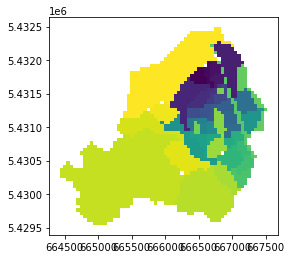

In [296]:
MODFLOW_gdf_SWMM.plot(column="id")

## Map extern domain

<AxesSubplot:>

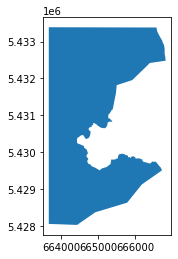

In [297]:
extern_active_gdf=gpd.read_file('GIS/SHAPES/extern_active.shp')
extern_active_gdf.plot()

- Spatial Join

In [298]:
map_extern_to_MFgrid_gdf=gpd.sjoin(MODFLOW_centroid, extern_active_gdf, how="left", op='intersects')
map_extern_to_MFgrid_gdf

,geometry,node,index_right,id
0,POINT (663801.000 5433015.000),1,0.0,1.0
1,POINT (663851.000 5433015.000),2,0.0,1.0
2,POINT (663901.000 5433015.000),3,0.0,1.0
3,POINT (663951.000 5433015.000),4,0.0,1.0
4,POINT (664001.000 5433015.000),5,0.0,1.0
...,...,...,...,...
9995,POINT (668551.000 5428065.000),9996,NaN,NaN
9996,POINT (668601.000 5428065.000),9997,NaN,NaN
9997,POINT (668651.000 5428065.000),9998,NaN,NaN
9998,POINT (668701.000 5428065.000),9999,NaN,NaN


In [299]:
MODFLOW_gdf_SWMM

,node,row,column,geometry,elevation,ibound,inactive,river,lake,id,S,%imperv,DRN
0,1,1,1,"POLYGON ((663776.000 5433040.000, 663826.000 5...",118.4375,1,False,False,False,NaN,NaN,NaN,1
1,2,1,2,"POLYGON ((663826.000 5433040.000, 663876.000 5...",120.5000,1,False,False,False,NaN,NaN,NaN,1
2,3,1,3,"POLYGON ((663876.000 5433040.000, 663926.000 5...",120.4375,1,False,False,False,NaN,NaN,NaN,1
3,4,1,4,"POLYGON ((663926.000 5433040.000, 663976.000 5...",118.9375,1,False,False,False,NaN,NaN,NaN,1
4,5,1,5,"POLYGON ((663976.000 5433040.000, 664026.000 5...",117.1875,1,False,False,False,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,100,96,"POLYGON ((668526.000 5428090.000, 668576.000 5...",80.3750,0,True,False,False,NaN,NaN,NaN,1
9996,9997,100,97,"POLYGON ((668576.000 5428090.000, 668626.000 5...",70.0625,0,True,False,False,NaN,NaN,NaN,1
9997,9998,100,98,"POLYGON ((668626.000 5428090.000, 668676.000 5...",64.1250,0,True,False,False,NaN,NaN,NaN,1
9998,9999,100,99,"POLYGON ((668676.000 5428090.000, 668726.000 5...",64.5000,0,True,False,False,NaN,NaN,NaN,1


In [300]:
MODFLOW_gdf_SWMM=MODFLOW_gdf_SWMM.join(map_extern_to_MFgrid_gdf,rsuffix='_right')

In [301]:
MODFLOW_gdf_SWMM=MODFLOW_gdf_SWMM.drop(columns=["geometry_right","node_right","index_right"])             

<AxesSubplot:>

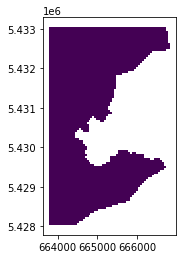

In [302]:
MODFLOW_gdf_SWMM=MODFLOW_gdf_SWMM.rename(columns={"id_right": "active_extern"})
MODFLOW_gdf_SWMM.plot(column="active_extern")

In [303]:
MODFLOW_gdf_SWMM

,node,row,column,geometry,elevation,ibound,inactive,river,lake,id,S,%imperv,DRN,active_extern
0,1,1,1,"POLYGON ((663776.000 5433040.000, 663826.000 5...",118.4375,1,False,False,False,NaN,NaN,NaN,1,1.0
1,2,1,2,"POLYGON ((663826.000 5433040.000, 663876.000 5...",120.5000,1,False,False,False,NaN,NaN,NaN,1,1.0
2,3,1,3,"POLYGON ((663876.000 5433040.000, 663926.000 5...",120.4375,1,False,False,False,NaN,NaN,NaN,1,1.0
3,4,1,4,"POLYGON ((663926.000 5433040.000, 663976.000 5...",118.9375,1,False,False,False,NaN,NaN,NaN,1,1.0
4,5,1,5,"POLYGON ((663976.000 5433040.000, 664026.000 5...",117.1875,1,False,False,False,NaN,NaN,NaN,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,100,96,"POLYGON ((668526.000 5428090.000, 668576.000 5...",80.3750,0,True,False,False,NaN,NaN,NaN,1,NaN
9996,9997,100,97,"POLYGON ((668576.000 5428090.000, 668626.000 5...",70.0625,0,True,False,False,NaN,NaN,NaN,1,NaN
9997,9998,100,98,"POLYGON ((668626.000 5428090.000, 668676.000 5...",64.1250,0,True,False,False,NaN,NaN,NaN,1,NaN
9998,9999,100,99,"POLYGON ((668676.000 5428090.000, 668726.000 5...",64.5000,0,True,False,False,NaN,NaN,NaN,1,NaN


### Counting Nan Cells and "Double" cells:

In [304]:
MODFLOW_gdf_SWMM["Nan_cell"]=0
MODFLOW_gdf_SWMM["Double_cell"]=0
for i in range(len(MODFLOW_gdf_SWMM["DRN"])):
    if MODFLOW_gdf_SWMM["ibound"][i]==1 and type(MODFLOW_gdf_SWMM["S"][i])!=str and MODFLOW_gdf_SWMM["active_extern"][i]!=1:
        MODFLOW_gdf_SWMM["Nan_cell"][i]=1
    if MODFLOW_gdf_SWMM["ibound"][i]==-1 and type(MODFLOW_gdf_SWMM["S"][i])==str:
        MODFLOW_gdf_SWMM["Double_cell"][i]=1
    if MODFLOW_gdf_SWMM["active_extern"][i]==1 and type(MODFLOW_gdf_SWMM["S"][i])==str:
        MODFLOW_gdf_SWMM["Double_cell"][i]=1

C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


<AxesSubplot:>

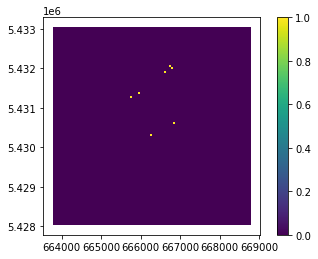

In [305]:
MODFLOW_gdf_SWMM.plot(column="Nan_cell", legend=True)

<AxesSubplot:>

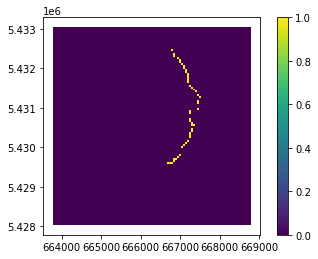

In [306]:
MODFLOW_gdf_SWMM.plot(column="Double_cell", legend=True)

### Correct Nan cells: take the closest subcatchment

In [307]:
for i in range(len(MODFLOW_gdf_SWMM["DRN"])):
    if MODFLOW_gdf_SWMM["ibound"][i]==1 and type(MODFLOW_gdf_SWMM["S"][i])!=str and MODFLOW_gdf_SWMM["active_extern"][i]!=1:
        MODFLOW_gdf_SWMM["S"][i]=MODFLOW_gdf_SWMM["S"][i-1]
        MODFLOW_gdf_SWMM["id"][i]=MODFLOW_gdf_SWMM["id"][i-1]    
    if MODFLOW_gdf_SWMM["ibound"][i]==-1 and type(MODFLOW_gdf_SWMM["S"][i])==str:
        MODFLOW_gdf_SWMM["S"][i]=np.nan
        MODFLOW_gdf_SWMM["id"][i]=np.nan

C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we

<AxesSubplot:>

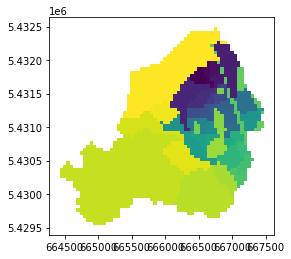

In [308]:
MODFLOW_gdf_SWMM.plot(column="id")

In [309]:
S_areas_cells=MODFLOW_gdf_SWMM.groupby("S").node.count()*x_resolution*y_resolution

In [310]:
S_areas_modflow=[]
for s in S_names_list:
    if s in S_areas_cells.index:
        S_areas_modflow.append(S_areas_cells[s])

In [311]:
for i in range(len(S_areas)):
    print(S_names_list[i], S_areas[i]*10000/S_areas_modflow[i])

S1 0.8488888888888889
S2 0.8866666666666667
S3 1.0133333333333334
S4 1.0145454545454546
S5 1.1
S6 1.053939393939394
S7 1.0278260869565217
S8 1.32
S9 1.1439999999999997
S10 0.9
S11 0.944
S12 0.94
S13 0.8436363636363636
S14 0.96
S15 0.9786666666666665
S16 1.0325
S17 0.9833333333333333
S18 0.9882352941176471
S19 0.8514285714285714
S20 1.133333333333333
S21 0.59
S22 1.0666666666666667
S23 1.04
S24 0.9999999999999999
S25 0.9655172413793104
S26 1.046857142857143
S27 0.97
S28 1.0514285714285714
S29 1.0514285714285714
S30 0.9818181818181818
S31 0.9988571428571429
S32 0.9966666666666666
S33 1.125
S34 1.336470588235294
S35 1.0942857142857143
S36 1.7200000000000002
S37 1.2285714285714286
S_W1 0.8534
S_W2 0.97064
S_W3 0.9146857142857144
S_W4 1.0592457142857143
E1 1.0395604395604396
E2 0.9962616822429906
E3 1.0244444444444445
E4 0.983013698630137
E5 1.0162162162162163
E6 0.9975221238938055


## Map SWMM Sorage Units to MODFLOW grid

### MAP Wetlands Storage Units

<AxesSubplot:>

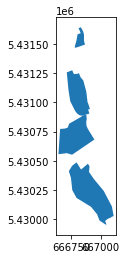

In [312]:
WSU_gdf=gpd.read_file('GIS/SHAPES/SWMM_WSU.shp')
WSU_gdf.plot()

In [313]:
WSU_gdf

,ID,AREA,SWMM_NAME,geometry
0,38,8534,W1,"POLYGON ((666811.347 5431634.569, 666830.845 5..."
1,40,64028,W3,"POLYGON ((666731.178 5430817.315, 666833.868 5..."
2,39,48532,W2,"POLYGON ((666710.620 5431256.407, 666757.083 5..."
3,41,92684,W4,"POLYGON ((666728.439 5430411.478, 666756.195 5..."


<AxesSubplot:>

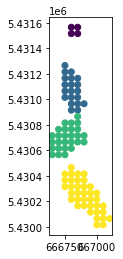

In [314]:
map_WSU_to_MFgrid_gdf=gpd.sjoin(MODFLOW_centroid,WSU_gdf, how="left", op='intersects')
map_WSU_to_MFgrid_gdf.plot(column="ID")

In [315]:
MODFLOW_gdf_SWMM=MODFLOW_gdf_SWMM.join(map_WSU_to_MFgrid_gdf,rsuffix='_right')

In [316]:
MODFLOW_gdf_SWMM=MODFLOW_gdf_SWMM.drop(columns=["geometry_right","node_right","index_right", "AREA","ID"])      
MODFLOW_gdf_SWMM=MODFLOW_gdf_SWMM.rename(columns={"SWMM_NAME": "WSU"})

In [317]:
WSU_areas_cells=MODFLOW_gdf_SWMM.groupby("WSU").node.count()*x_resolution*y_resolution
WSU_areas_modflow=[]
for wsu in WSU_names_list:
    if wsu in WSU_areas_cells.index:
        WSU_areas_modflow.append(WSU_areas_cells[wsu])

In [318]:
 WSU_areas_modflow

[10000.0, 50000.0, 67500.0, 92500.0]

### Map floodable Storage Units

<AxesSubplot:>

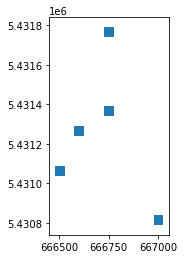

In [319]:
FSU_gdf=gpd.read_file('GIS/SHAPES/flood_zone.shp')
FSU_gdf.plot()

In [320]:
FSU_gdf

,id,SWMM_NAME,geometry
0,4,SU4,"POLYGON ((666726.066 5431740.000, 666726.066 5..."
1,5,SU5,"POLYGON ((666726.183 5431340.490, 666726.183 5..."
2,3,SU3,"POLYGON ((666576.023 5431240.656, 666576.023 5..."
3,2,SU2,"POLYGON ((666476.540 5431039.820, 666476.540 5..."
4,1,SU1,"POLYGON ((666976.059 5430790.411, 666976.059 5..."


<AxesSubplot:>

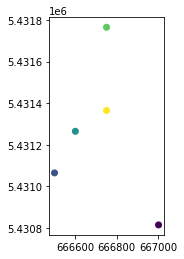

In [321]:
map_FSU_to_MFgrid_gdf=gpd.sjoin(MODFLOW_centroid,FSU_gdf, how="left", op='intersects')
map_FSU_to_MFgrid_gdf.plot(column="id")

In [322]:
MODFLOW_gdf_SWMM=MODFLOW_gdf_SWMM.join(map_FSU_to_MFgrid_gdf,rsuffix='_right')

In [323]:
MODFLOW_gdf_SWMM=MODFLOW_gdf_SWMM.drop(columns=["geometry_right","node_right","index_right","id_right"])      
MODFLOW_gdf_SWMM=MODFLOW_gdf_SWMM.rename(columns={"SWMM_NAME": "FSU"})

In [324]:
FSU_areas_cells=MODFLOW_gdf_SWMM.groupby("FSU").node.count()*x_resolution*y_resolution
FSU_areas_modflow=[]
for fsu in FSU_names_list:
    if fsu in FSU_areas_cells.index:
        FSU_areas_modflow.append(FSU_areas_cells[fsu])

In [325]:
FSU_areas_modflow

[2500.0, 2500.0, 2500.0, 2500.0, 2500.0]

## Map MODFLOW DRN cells to Junctions or Storage Units

### Map drain cells in MODFLOW (Teodosio Sarao) to closest SW routing node in SWMM

<AxesSubplot:>

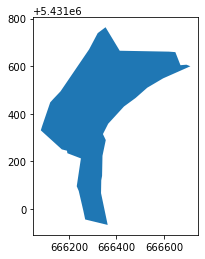

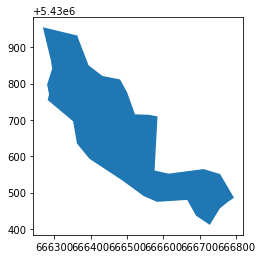

In [326]:
SWMM_TS1_gdf=gpd.read_file('GIS/SHAPES/Teodosio_Sarao_zone1.shp')
SWMM_TS2_gdf=gpd.read_file('GIS/SHAPES/Teodosio_Sarao_zone2.shp')
SWMM_TS1_gdf.plot()
SWMM_TS2_gdf.plot()

<AxesSubplot:>

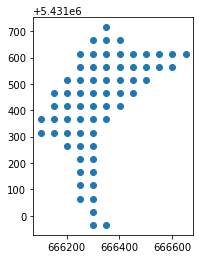

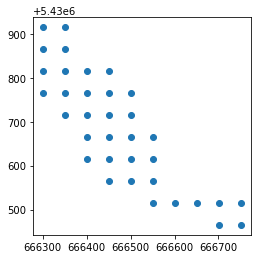

In [327]:
map_TS1_to_MFcentroid_gdf=gpd.sjoin(MODFLOW_centroid, SWMM_TS1_gdf, how="inner", op='intersects')
map_TS1_to_MFcentroid_gdf.plot()

map_TS2_to_MFcentroid_gdf=gpd.sjoin(MODFLOW_centroid, SWMM_TS2_gdf, how="inner", op='intersects')
map_TS2_to_MFcentroid_gdf.plot()

<AxesSubplot:>

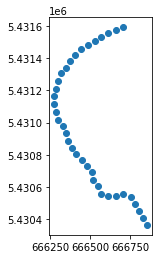

In [328]:
SWMM_pointsTS_gdf = gpd.read_file('GIS/SHAPES/points_teodosio_sarao.shp')
SWMM_pointsTS_gdf.plot()

In [329]:
gpd1 = map_TS1_to_MFcentroid_gdf
gpd2 = map_TS2_to_MFcentroid_gdf
gpd3 = SWMM_pointsTS_gdf

def ckdnearest(gdA, gdB):
    nA = np.array(list(zip(gdA.centroid.x, gdA.centroid.y)) )
    nB = np.array(list(zip(gdB.geometry.x, gdB.geometry.y)) )
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=1)
    gdf = pd.concat(
        [gdA.reset_index(drop=True), gdB.loc[idx, gdB.columns != 'geometry'].reset_index(drop=True),
         pd.Series(dist, name='dist')], axis=1)
    return gdf

map_MFdraincells_to_TS1routingnodes_gdf = ckdnearest(gpd1, gpd3)
map_MFdraincells_to_TS2routingnodes_gdf = ckdnearest(gpd2, gpd3)

<AxesSubplot:>

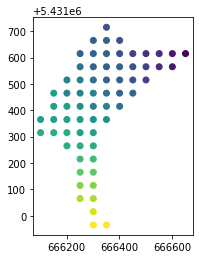

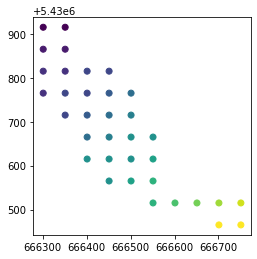

In [330]:
map_MFdraincells_to_TS1routingnodes_gdf.plot(column='fid')
map_MFdraincells_to_TS2routingnodes_gdf.plot(column='fid')

In [331]:
map_MFdraincells_to_TS_gdf=pd.concat([map_MFdraincells_to_TS1routingnodes_gdf, map_MFdraincells_to_TS2routingnodes_gdf])
map_MFdraincells_to_TS_gdf=map_MFdraincells_to_TS_gdf.drop(["fid", "geometry","index_right","ID","dist", "AREA", "SWMM_NAME"], axis=1)
map_MFdraincells_to_TS_gdf=map_MFdraincells_to_TS_gdf.rename(columns={"SWMM_NAM_1": "drn_to_TS"})
map_MFdraincells_to_TS_gdf

,node,drn_to_TS
0,2652,TS6
1,2751,TS7
2,2752,TS7
3,2753,TS6
4,2850,TS7
...,...,...
30,5058,TS30
31,5059,TS31
32,5060,TS32
33,5159,TS33


## Map SWMM zones (subcatchments) to storage units or junctions

In [332]:
drnto_df = pd.read_excel("drn_to.xlsx")

C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\xlrd\xlsx.py:266: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\xlrd\xlsx.py:312: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\xlrd\xlsx.py:266: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():


In [333]:
MODFLOW_gdf_SWMM=MODFLOW_gdf_SWMM.merge(drnto_df, on="S", how="left" )

In [334]:
MODFLOW_gdf_SWMM=MODFLOW_gdf_SWMM.merge(map_MFdraincells_to_TS_gdf, on="node", how="left" )

In [335]:
contador=0
for i in range(len(MODFLOW_gdf_SWMM.drn_to)):
    if type(MODFLOW_gdf_SWMM.drn_to[i])!=str:
        if type(MODFLOW_gdf_SWMM.drn_to_TS[i])==str:
            MODFLOW_gdf_SWMM.drn_to[i]=MODFLOW_gdf_SWMM.drn_to_TS[i]
            contador+=1
print(contador)

C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


101


In [336]:
MODFLOW_gdf_SWMM=MODFLOW_gdf_SWMM.drop(columns=["drn_to_TS"])

### Check that every cell that drains has a node on SWMM model

Solo las celdas activas externas al dominio SWMM drenan sin seer incorporadas a un nodo

In [337]:
contador=0
for i in range(len(MODFLOW_gdf_SWMM.drn_to)):
    if MODFLOW_gdf_SWMM["ibound"][i]==1:
        if not (MODFLOW_gdf_SWMM["active_extern"][i]==1):
            if MODFLOW_gdf_SWMM["DRN"][i]==1 and type(MODFLOW_gdf_SWMM["drn_to"][i])!=str:
                contador+=1
contador

0

## Zone Budget using SWMM subcatchments:

In [338]:
MODFLOW_gdf_SWMM

,node,row,column,geometry,elevation,ibound,inactive,river,lake,id,S,%imperv,DRN,active_extern,Nan_cell,Double_cell,WSU,FSU,drn_to
0,1,1,1,"POLYGON ((663776.000 5433040.000, 663826.000 5...",118.4375,1,False,False,False,NaN,NaN,NaN,1,1.0,0,0,NaN,NaN,NaN
1,2,1,2,"POLYGON ((663826.000 5433040.000, 663876.000 5...",120.5000,1,False,False,False,NaN,NaN,NaN,1,1.0,0,0,NaN,NaN,NaN
2,3,1,3,"POLYGON ((663876.000 5433040.000, 663926.000 5...",120.4375,1,False,False,False,NaN,NaN,NaN,1,1.0,0,0,NaN,NaN,NaN
3,4,1,4,"POLYGON ((663926.000 5433040.000, 663976.000 5...",118.9375,1,False,False,False,NaN,NaN,NaN,1,1.0,0,0,NaN,NaN,NaN
4,5,1,5,"POLYGON ((663976.000 5433040.000, 664026.000 5...",117.1875,1,False,False,False,NaN,NaN,NaN,1,1.0,0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,100,96,"POLYGON ((668526.000 5428090.000, 668576.000 5...",80.3750,0,True,False,False,NaN,NaN,NaN,1,NaN,0,0,NaN,NaN,NaN
9996,9997,100,97,"POLYGON ((668576.000 5428090.000, 668626.000 5...",70.0625,0,True,False,False,NaN,NaN,NaN,1,NaN,0,0,NaN,NaN,NaN
9997,9998,100,98,"POLYGON ((668626.000 5428090.000, 668676.000 5...",64.1250,0,True,False,False,NaN,NaN,NaN,1,NaN,0,0,NaN,NaN,NaN
9998,9999,100,99,"POLYGON ((668676.000 5428090.000, 668726.000 5...",64.5000,0,True,False,False,NaN,NaN,NaN,1,NaN,0,0,NaN,NaN,NaN


In [339]:
MODFLOW_gdf_SWMM["zon"]=1
aliases = {1: 'Active_Extern' }

In [340]:
contador=2
MODFLOW_gdf_SWMM.loc[MODFLOW_gdf_SWMM.lake == True, 'zon'] = contador
aliases.update({contador:"Lake"})

In [341]:
contador=contador+1
MODFLOW_gdf_SWMM.loc[MODFLOW_gdf_SWMM.river == True, 'zon'] = contador
aliases.update({contador:"River"})

In [342]:
contador=contador+1
MODFLOW_gdf_SWMM.loc[MODFLOW_gdf_SWMM.inactive == True, 'zon'] = contador
aliases.update({contador:"Inactive"})

In [343]:
contador=contador+1
for i in range(len(S_names_list)):
    MODFLOW_gdf_SWMM.loc[MODFLOW_gdf_SWMM.S == S_names_list[i], 'zon'] = contador
    aliases.update({contador: S_names_list[i]})
    contador=contador+1

<AxesSubplot:>

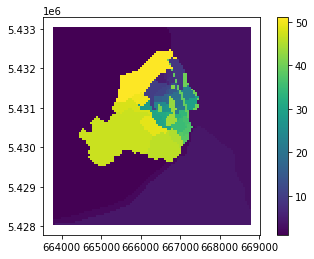

In [344]:
MODFLOW_gdf_SWMM.plot(column="zon", legend=True)

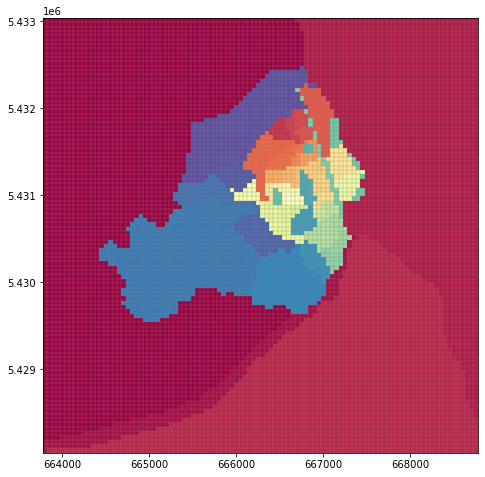

In [345]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

ax = MODFLOW_gdf_SWMM.plot(ax=ax, column="zon",  cmap='Spectral')
#plt.colorbar(ax.images[0], shrink=0.7)
pmv = flopy.plot.PlotMapView(modelgrid=ml.modelgrid)
pmv.plot_grid(ax=ax, alpha=0.2);

In [346]:
zon = np.zeros((nlay,nrows,ncols)) 

for index, row in MODFLOW_gdf_SWMM.iterrows():
    zon[:,row['row']-1,row['column']-1] = row['zon']

zon=zon[0].astype(np.int64)

In [347]:
ZB_TS=[]

# Loop for Temporal/Spatial Data Exchange

- Rewrite DIS package

In [348]:
perlen,nstp,nper,steady = 1, 1, 1, False
dis = flopy.modflow.ModflowDis(ml, nlay=nlay, nrow=nrows, ncol=ncols,delr=delr, delc=delc, top=L1_top, botm=bottom, nper=nper, perlen=perlen, nstp=nstp, steady=steady)

****Warning -- two packages of the same type:  <class 'flopy.modflow.mfdis.ModflowDis'> <class 'flopy.modflow.mfdis.ModflowDis'>
replacing existing Package...


In [349]:
TS_gdf=[]

In [134]:
strt = heads[0]

In [350]:
with Simulation(SWMM_path) as sim:
    
    system_routing = SystemStats(sim)
    #Lists of cummulative infiltration to calculate delta infiltratation for every time step: S, WSU and FSU 
    inf_S_list_1=np.zeros(len(S_list))
    inf_S_list_2=np.zeros(len(S_list))
    inf_WSU_list_1=np.zeros(len(WSU_list))
    inf_WSU_list_2=np.zeros(len(WSU_list))
    inf_FSU_list_1=np.zeros(len(FSU_list))
    inf_FSU_list_2=np.zeros(len(FSU_list))
    
    #Lists for the DRN incorporation
    rate_J_list=np.zeros(len(J_list))
    rate_WSU_list=np.zeros(len(WSU_list))
    rate_FSU_list=np.zeros(len(FSU_list))
    
    #time counter for daily infiltration agregation and hourly reports
    step_counter=0
    day_counter=0
    hourly_counter=0
    for step in sim:
        step_counter=step_counter+1

        #Rainfall modificaction to avoid double count on evt:
#         for i in range(len(RG_list[:-1]):
#             p1=RG_list[-1].total_precip
#             p2=p1+SU_S_list[i].evaporation_loss/24.
#             RG_list[i].total_precip=p2

        if step_counter==120:
            step_counter=0
            hourly_counter+=1
            
            # TIME SERIES RESULTS: 1HR AS REPORT TIME STEP
            
            #SUBCATCHMENTS TIME SERIES RESULTS
            for i in range(len(S_list)):
                new_row = {'Time': sim.current_time, "Precipitation (mm/h)":S_list[i].rainfall, 
                           "Evaporation (mm/d)":S_list[i].evaporation_loss,"Infiltration (mm/h)":S_list[i].infiltration_loss, 
                           "Runoff (m3/s)":S_list[i].runoff,"Runon (m3/s)":S_list[i].runon,
                           "Cumulative Infiltration (m3)": S_list[i].statistics["infiltration"], "Cumulative Evaporation (m3)": S_list[i].statistics["evaporation"]}
                S_SWMM_TS[i] =S_SWMM_TS[i].append(new_row, ignore_index=True)

            #WETLAND STORAGE UNITS TIME SERIES RESULTS
            for i in range(len(WSU_list)):
                new_row = {'Time': sim.current_time, "Depth (m)":WSU_list[i].depth, 
                           "Head (m)":WSU_list[i].head, "Flooding (m3/s)":WSU_list[i].flooding, 
                           "Lateral inflow (m3/s)":WSU_list[i].lateral_inflow,"Total inflow (m3/s)":WSU_list[i].total_inflow,
                           "Total outflow (m3/s)":WSU_list[i].total_outflow, "Volume (m3)":WSU_list[i].volume, "Losses (m3/s)":WSU_list[i].losses,
                           "Cumulative Exfiltration Loss (m3)": WSU_list[i].storage_statistics["exfil_loss"], "Cumulative Evaporation Loss (m3)": WSU_list[i].storage_statistics["evap_loss"]}
                WSU_SWMM_TS[i] =WSU_SWMM_TS[i].append(new_row, ignore_index=True)
            #FLOOD STORAGE UNITS TIME SERIES RESULTS
            for i in range(len(FSU_list)):
                new_row = {'Time': sim.current_time, "Depth (m)":FSU_list[i].depth, 
                           "Head (m)":FSU_list[i].head, "Flooding (m3/s)":FSU_list[i].flooding, 
                           "Lateral inflow (m3/s)":FSU_list[i].lateral_inflow,"Total inflow (m3/s)":FSU_list[i].total_inflow,
                           "Total outflow (m3/s)":FSU_list[i].total_outflow, "Volume (m3)":FSU_list[i].volume, "Losses (m3/s)":FSU_list[i].losses,
                           "Cumulative Exfiltration Loss (m3)": FSU_list[i].storage_statistics["exfil_loss"], "Cumulative Evaporation Loss (m3)": FSU_list[i].storage_statistics["evap_loss"]}
                FSU_SWMM_TS[i] =FSU_SWMM_TS[i].append(new_row, ignore_index=True)
                
            #NODES TIME SERIES RESULTS
            for i in range(len(J_list)):
                new_row = {'Time': sim.current_time, "Depth (m)":J_list[i].depth, 
                          "Head (m)":J_list[i].head, "Flooding (m3/s)":J_list[i].flooding, 
                          "Lateral inflow (m3/s)":J_list[i].lateral_inflow,"Total inflow (m3/s)":J_list[i].total_inflow,
                          "Total outflow (m3/s)":J_list[i].total_outflow}
                J_SWMM_TS[i] =J_SWMM_TS[i].append(new_row, ignore_index=True) 
                
                
            #CONDUITS TIME SERIES RESULTS
            for i in range(len(C_list)):
                new_row = {'Time': sim.current_time, "Depth (m)":C_list[i].depth, 
                           "Flow (m3/s)":C_list[i].flow}
                C_SWMM_TS[i] =C_SWMM_TS[i].append(new_row, ignore_index=True)
            
            # WEIRS TIME SERIES RESULTS
            for i in range(len(V_list)):
                new_row = {'Time': sim.current_time, "Depth (m)":V_list[i].depth, 
                          "Flow (m3/s)":V_list[i].flow}
                V_SWMM_TS[i] =V_SWMM_TS[i].append(new_row, ignore_index=True)          
        
        #DAILY INFILTRATION ON S, WSU AND FSU:
        
        if hourly_counter==24:
            day_counter=day_counter+1
            hourly_counter=0
            
            print(sim.current_time)

            for i in range(len(S_list)):
                #Delta infiltration
                
                inf_S_list_2[i]=(S_list[i].statistics["infiltration"]-inf_S_list_1[i])
                inf_S_list_1[i]=S_list[i].statistics["infiltration"]
                
            for i in range(len(WSU_list)):
                #Delta infiltration
                inf_WSU_list_2[i]=(WSU_list[i].storage_statistics["exfil_loss"]-inf_WSU_list_1[i])
                inf_WSU_list_1[i]=WSU_list[i].storage_statistics["exfil_loss"]

            for i in range(len(FSU_list)):
                #Delta infiltration
                inf_FSU_list_2[i]=(FSU_list[i].storage_statistics["exfil_loss"]-inf_FSU_list_1[i])
                inf_FSU_list_1[i]=FSU_list[i].storage_statistics["exfil_loss"]

                
            RCH_S=inf_S_list_2
            RCH_WSU=inf_WSU_list_2
            RCH_FSU=inf_FSU_list_2

            #CHANGE OF UNITS m3/dia->m/dia:
    
            RCH_S_M=RCH_S/(np.array(S_areas_modflow))
            RCH_WSU_M=RCH_WSU/(np.array(WSU_areas_modflow))
            RCH_FSU_M=RCH_FSU/(np.array(FSU_areas_modflow))            
        
            RCH_S_df=pd.DataFrame({"S":S_names_list, "RCH_S":RCH_S_M})
            RCH_WSU_df=pd.DataFrame({"WSU":WSU_names_list, "RCH_WSU":RCH_WSU_M})
            RCH_FSU_df=pd.DataFrame({"FSU":FSU_names_list, "RCH_FSU":RCH_FSU_M})
            
            #Gereferenced RCH: Add to the MODFLOW_gdf_test new columns RCH_S, RCH_WSU, RCH_FSU
            
            MODFLOW_gdf_loop=pd.DataFrame()
            
            MODFLOW_gdf_loop=pd.merge(MODFLOW_gdf_SWMM, RCH_S_df, on="S", how="left")
            MODFLOW_gdf_loop=pd.merge(MODFLOW_gdf_loop, RCH_WSU_df, on="WSU", how="left")
            MODFLOW_gdf_loop=pd.merge(MODFLOW_gdf_loop, RCH_FSU_df, on="FSU", how="left")
            
            # Sum georeferences RCHs
            
            MODFLOW_gdf_loop["RCH"]= MODFLOW_gdf_loop.RCH_S.fillna(0) + MODFLOW_gdf_loop.RCH_WSU.fillna(0) +  MODFLOW_gdf_loop.RCH_FSU.fillna(0)
            
            #Create MODFLOW inputs: RCH package
            
            rch_array = np.zeros((nrows,ncols))
            recharge_cells = MODFLOW_gdf_SWMM.index.values
            for cell in recharge_cells:
                row = MODFLOW_gdf_loop.row[cell]
                col = MODFLOW_gdf_loop.column[cell]
                flux = MODFLOW_gdf_loop.RCH[cell]
                rch_array[row - 1][col - 1] = flux
            rch_array[np.isnan(rch_array)] = 0.
        
            rch = flopy.modflow.ModflowRch(ml, nrchop=3,rech=rch_array, ipakcb=53)
            
            bas = flopy.modflow.ModflowBas(ml, ibound=ibound, strt=strt) #use the head table of the last time step
           
            #Run MODFLOW
            
            ml.write_input()
            ml.run_model(silent=True)
            
            #Read MODFLOW outputs
            fname = os.path.join('LLANQUIHUE_MF_workspace', 'LLANQUIHUE.hds')
            headfile = flopy.utils.HeadFile(fname, model=ml)
            heads = headfile.get_data()
            heads[heads==1.e+30] = np.nan            # fix masked data 
            heads[heads==-999.99] = np.nan

            #Strt next loop
            
            strt = heads[0]
            
            top = ml.dis.top.array
            DTWT = (top-DRN_burn_depth)-heads[0]  
            
            #DRN calculation
            
            delta_H=np.reshape(DTWT, len(MODFLOW_gdf_loop))
            altura=np.reshape(heads[0], len(MODFLOW_gdf_loop))
            for i in range(len(delta_H)):
                if delta_H[i]<0:
                    delta_H[i]=-delta_H[i]
                else:
                     delta_H[i]=0.
            MODFLOW_gdf_loop["Altura"]=altura   
            MODFLOW_gdf_loop["delta_H"]=delta_H
            MODFLOW_gdf_loop["DRN_rate"]=0.
            
            for i in range(len(MODFLOW_gdf_loop["DRN"])):
                if MODFLOW_gdf_loop["DRN"][i]==1:
                    MODFLOW_gdf_loop["DRN_rate"][i]=(delta_H[i])*DRN_C
            
            #INFLOW RATES IN WSU, FSU AND JUNCTIONS
            
            #Inflow rates in WSU:
            
            inflow_WSU=MODFLOW_gdf_loop.groupby("drn_to").sum()["DRN_rate"]
            inflow_WSU_list=[]
            for w in WSU_names_list:
                if w in inflow_WSU.index:
                    inflow_WSU_list.append(inflow_WSU[w])
                else:
                    inflow_WSU_list.append(0.)
                    
            #Inflow rates in FSU:
            
            inflow_FSU=MODFLOW_gdf_loop.groupby("drn_to").sum()["DRN_rate"]
            inflow_FSU_list=[]
            for f in FSU_names_list:
                if f in inflow_FSU.index:
                    inflow_FSU_list.append(inflow_FSU[f])
                else:
                    inflow_WSU_list.append(0.)
                    
            #Inflow rate in Junctions
            
            inflow_j=MODFLOW_gdf_loop.groupby("drn_to").sum()["DRN_rate"]
            inflow_j_list=[]
            for j in J_names_list:
                if j in inflow_j.index:
                    inflow_j_list.append(inflow_j[j])
                else:
                    inflow_j_list.append(0.)
                
            #Generated inflow SWMM WSU:
            
            for i in range(len(WSU_list)):
                rate=inflow_WSU_list[i]/86400. #m3/s
                WSU_list[i].generated_inflow(rate)
                
            #Generated inflow SWMM FSU:
            
            for i in range(len(FSU_list)):
                rate=inflow_FSU_list[i]/86400. #m3/s
                FSU_list[i].generated_inflow(rate)
                
            #Generated inflow SWMM Junctions:
            
            for i in range(len(J_list)):
                rate=inflow_j_list[i]/86400 #m3/s
                J_list[i].generated_inflow(rate)
                
#            #MODFLOW evaporation on perv cells
#             MODFLOW_gdf_test["RET"]=0
#             MODFLOW_gdf_test.loc[MODFLOW_gdf_test.Altura<(MODFLOW_gdf["elevation"]-EXPD), 'RET']=0
#             MODFLOW_gdf_test.loc[MODFLOW_gdf_test.Altura>(MODFLOW_gdf["elevation"]-EXPD), 'RET'] = MODFLOW_gdf["EVT"]*EVTR*(MODFLOW_gdf_test["Altura"]-(MODFLOW_gdf["elevation"]-EXPD))/EXPD
#             MODFLOW_gdf_test.loc[MODFLOW_gdf_test.Altura>MODFLOW_gdf["elevation"], 'RET'] = EVTR*MODFLOW_gdf["EVT"]
            
            
#             MODFLOW_gdf_test["Altura_EVT"]=MODFLOW_gdf_test["Altura"]-MODFLOW_gdf_test["RET"]
            
            #Strt next loop
        
#             strt = np.ones((nlay,nrows,ncols)) 
#             for index, row in MODFLOW_gdf_loop.iterrows():
#                 strt[:,row['row']-1,row['column']-1] = row["Altura_EVT"] 
                
            #Save MODFLOW cells information
            TS_gdf.append(MODFLOW_gdf_loop)
            
                
            #Save zonebudget DataFrame
            fname = os.path.join('LLANQUIHUE_MF_workspace', 'LLANQUIHUE.cbc')
            cbb = flopy.utils.CellBudgetFile(fname)
            zb = flopy.utils.ZoneBudget(cbb, zon, aliases=aliases)
            zb_df=zb.get_dataframes()
            ZB_TS.append(zb_df)
            
#             #Continuity
#             inf=sum(RCH_S)+sum(RCH_WSU)+sum(RCH_FSU)
#             rch=sum(rch_array)*x_resolution*y_resolution
#             print("inf/rch:", inf/rch)
            
                
    routing_stats=system_routing.routing_stats
    runoff_stats=system_routing.runoff_stats
            
print("Flow Routing Mass Balance Error:", sim.flow_routing_error)
print("Runoff Mass Balance Error:", sim.runoff_error)

2018-05-02 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-05-03 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...
2018-05-04 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...
2018-05-05 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existi

# Results

In [364]:
df_routing_couple = pd.DataFrame({'Dry Weather Inflow (m3)': [routing_stats['dry_weather_inflow']],
                   'Wet Weather Inflow (m3)': [routing_stats['wet_weather_inflow']], 
                   'Ground Water Inflow (m3)': [routing_stats['groundwater_inflow']],
                   #'RDII Inflow (m3)': [routing_stats['II_inflow']],
                   'External Inflow (m3)': [routing_stats['external_inflow']],
                   'External Outflow (m3)': [routing_stats['outflow']],
                   'Flooding Loss (m3)': [routing_stats['flooding']],
                   'Evaporation Loss (m3)': [routing_stats['evaporation_loss']],
                   'Seepage Loss (m3)': [routing_stats['seepage_loss']],
                   'Initial Stored Volume': [routing_stats['initial_storage']],
                   'Final Stored Volume': [routing_stats['final_storage']]})

In [365]:
df_runoff_couple = pd.DataFrame({'Total Precipitation (mm)': [runoff_stats['rainfall']],
                   'Evaporation Loss (m3)': [runoff_stats['evaporation']], 
                   'Infiltration Loss (m3)': [runoff_stats['infiltration']],
                   'Runoff (m3)': [runoff_stats['runoff']],
                   "Initial Storage (mm)":[runoff_stats['init_storage']],
                   "Final Storage (mm)":[runoff_stats['final_storage']]})

In [419]:
df_routing_couple

,Dry Weather Inflow (m3),Wet Weather Inflow (m3),Ground Water Inflow (m3),External Inflow (m3),External Outflow (m3),Flooding Loss (m3),Evaporation Loss (m3),Seepage Loss (m3),Initial Stored Volume,Final Stored Volume
0,0.0,13529.932083,0.0,114267.083518,30472.9802,24159.054961,36.608785,43868.87361,1.541974e+06,1.232722e+06


In [354]:
df_runoff_couple

,Total Precipitation (mm),Evaporation Loss (m3),Infiltration Loss (m3),Runoff (m3),Initial Storage (mm),Final Storage (mm)
0,17.5,6278.355009,72355.806297,13529.932083,0.0,0.0


- Waorking with ZB output:

In [355]:
ZB_TS[0]=ZB_TS[0].reset_index(level=[0,1])

In [358]:
ZB_TS[0]

,totim,name,Active_Extern,Lake,River,Inactive,S1,S2,S3,S4,...,S_W1,S_W2,S_W3,S_W4,E1,E2,E3,E4,E5,E6
0,1.0,FROM_STORAGE,16245.213867,0.000000,0.000000,0.0,17.869745,19.087170,34.542095,11.287378,...,0.000000,0.000000,7.982522,0.000000,0.000000,0.915321,0.000000,0.000000,0.180732,17.040388
1,1.0,FROM_CONSTANT_HEAD,0.000000,55.849907,757.043518,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,1.0,FROM_DRAINS,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,1.0,FROM_RECHARGE,0.000000,0.000000,0.000000,0.0,20.905375,12.003262,18.971720,18.430618,...,92.112793,2360.680420,323.427795,6192.789062,1021.794312,3454.226562,398.348389,387.547363,203.062622,1826.268555
4,1.0,FROM_ZONE_0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,1.0,TO_E5,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,161.420670,0.000000,0.000000,209.689026
112,1.0,TO_E6,756.169556,0.000000,173.698441,0.0,0.000000,3.850012,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,103.033836,0.000000,67.245705,0.000000
113,1.0,TOTAL_OUT,17733.896484,5359.870117,1989.830566,0.0,414.197449,237.953674,206.078735,122.642059,...,295.528717,2591.971436,425.126556,6687.104492,1874.232422,4510.209473,1028.014404,1430.468872,739.702393,3011.827148
114,1.0,IN-OUT,0.009766,0.000488,0.000244,0.0,0.000305,0.000046,0.011993,0.000046,...,0.000061,0.001953,0.000122,0.006348,0.000366,0.000488,0.000000,0.000000,0.000061,0.000244


ZB by zone follows aliases index

In [366]:
columnas=ZB_TS[0].name
dias=np.linspace(0,int(len(ZB_TS)-1),int(len(ZB_TS)))

In [367]:
ZB_by_zone=[]
for z in aliases:
    zone=aliases[z]
    df_ZB=pd.DataFrame(index=dias)
    for i in columnas:
        df_ZB[i]=""
    for i in range(len(ZB_TS)):
        for j in range(len(columnas)):
            df_ZB[columnas[j]][i]=ZB_TS[i].iloc[j][zone]
    ZB_by_zone.append(df_ZB)

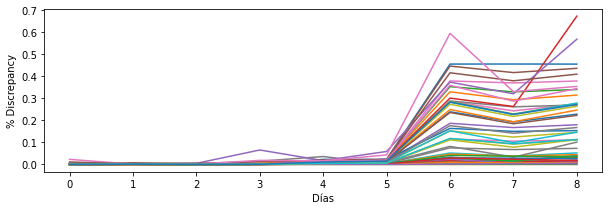

In [369]:
for i in range(len(ZB_by_zone)):
    ZB_by_zone[i]["PERCENT_DISCREPANCY"].plot(figsize=(10,3), label=aliases[i+1])
plt.ylabel("% Discrepancy")
plt.xlabel("Días")
#plt.legend()
plt.show()

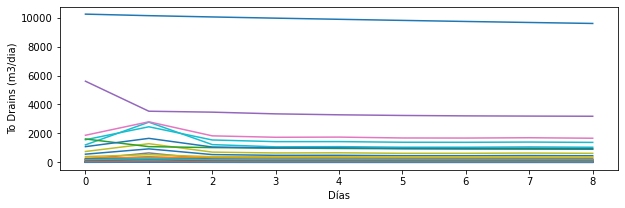

In [370]:
for i in range(len(ZB_by_zone)):
    ZB_by_zone[i]["TO_DRAINS"].plot(figsize=(10,3), label=aliases[i+1])
plt.ylabel("To Drains (m3/dia)")
plt.xlabel("Días")
#plt.legend()
plt.show()

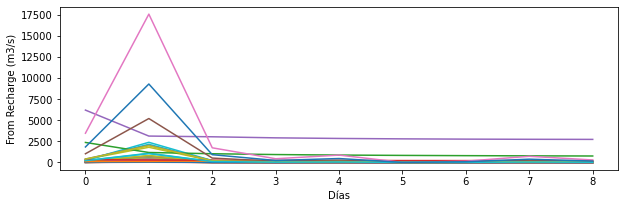

In [371]:
for i in range(len(ZB_by_zone)):
    ZB_by_zone[i]["FROM_RECHARGE"].plot(figsize=(10,3), label=aliases[i+1])
plt.ylabel("From Recharge (m3/s)")
#plt.legend()
plt.xlabel("Días")
plt.show()

## Continuity Analysis

### Coupling Continuity

- External Inflow in SWMM

In [372]:
E_in_s=df_routing_couple["External Inflow (m3)"][0]
E_in_s

114267.08351787293

- Drain water by MODFLOW using ZB:

In [373]:
DRN_S_m=0
contador=0
for i in range(len(aliases)):
    if aliases[i+1] in S_names_list:
        contador+=1
        DRN_S_m+=sum(list(ZB_by_zone[i]["TO_DRAINS"])[0:-1])

In [374]:
DRN_S_m

114013.66263389587

In [375]:
error_drn_inflow=((DRN_S_m)-E_in_s)/(DRN_S_m)*100
print("Continuity Coupling Error(DRN/INFLOW):",error_drn_inflow,"%")

Continuity Coupling Error(DRN/INFLOW): -0.22227238220633824 %


- Infiltration and Seepage Loss using SWMM output:

In [376]:
I_s=df_runoff_couple["Infiltration Loss (m3)"][0]
I_s

72355.80629658306

In [377]:
S_s=df_routing_couple["Seepage Loss (m3)"][0]
S_s

43868.87361006667

- Recharge in MODFLOW using ZB:

In [378]:
RCH_m=0
contador=0
for i in range(len(aliases)):
    if aliases[i+1] in S_names_list:
        contador+=1
        RCH_m+=sum(list(ZB_by_zone[i]["FROM_RECHARGE"]))

In [379]:
error_inf_rch=(RCH_m-I_s-S_s)/RCH_m*100
print("Continuity Coupling Error(INF/RCH):",error_inf_rch,"%")

Continuity Coupling Error(INF/RCH): -1.5231790062765058 %


### SWMM Continuity

In [380]:
P_s=df_runoff_couple["Total Precipitation (mm)"][0]*sum(S_areas)*10
P_s

92140.61590226257

In [381]:
E_out_s=df_routing_couple["External Outflow (m3)"][0]
E_out_s

30472.98020007169

In [382]:
E_out_s=df_routing_couple["External Outflow (m3)"][0]
E_out_s

30472.98020007169

In [383]:
F_s=df_routing_couple["Flooding Loss (m3)"][0]
F_s

24159.054961434616

In [384]:
EVT_s=df_runoff_couple["Evaporation Loss (m3)"][0]+df_routing_couple["Evaporation Loss (m3)"][0]
EVT_s

6314.963793754586

- Cambiar según .rpt file

In [387]:
S_f_s=72743+0*sum(S_areas)*10
S_i_s=43664
S_f_s

72743.0

In [388]:
SWMM_error=(1-(P_s+E_in_s-E_out_s-EVT_s-F_s-I_s-S_s)/(S_f_s-S_i_s))*100
print("SWMM Error:",SWMM_error, "%" )

SWMM Error: -0.5399792228923284 %


### MODFLOW Continuity

In [389]:
CH_in_m=0
CH_out_m=0
S_to_m=0
S_from_m=0
DRN_m=0
for i in range(len(aliases)):
        CH_in_m+=sum(list(ZB_by_zone[i]["FROM_CONSTANT_HEAD"]))
        CH_out_m+=sum(list(ZB_by_zone[i]["TO_CONSTANT_HEAD"]))
        S_to_m+=sum(list(ZB_by_zone[i]["TO_STORAGE"]))
        S_from_m+=sum(list(ZB_by_zone[i]["FROM_STORAGE"]))
        DRN_m+=sum(list(ZB_by_zone[i]["TO_DRAINS"]))

In [390]:
MODFLOW_error=(1-(RCH_m+CH_in_m-DRN_m-CH_out_m)/(S_to_m-S_from_m))*100
print("MODFLOW Error:",MODFLOW_error, "%" )

MODFLOW Error: 0.23362134661703005 %


### Global Continuity

In [391]:
DRN_ext_m=sum(list(ZB_by_zone[0]["TO_DRAINS"]))
DRN_ext_m

89057.42

In [392]:
dt_drn_m=0
for i in range(len(aliases)):
    if aliases[i+1] in S_names_list:
        dt_drn_m+=sum(list(ZB_by_zone[i]["TO_DRAINS"])[-1])
dt_drn_m        

12266.860996246338

In [393]:
DRN_m-(dt_drn_m+DRN_ext_m+DRN_S_m)

0.001735687255859375

In [394]:
DRN_S_m-E_in_s

-253.4208839770581

In [395]:
RCH_m-I_s-S_s

-1743.74949817195

In [396]:
GLOBAL_error=(1-(P_s+CH_in_m-(DRN_ext_m+dt_drn_m)-E_out_s-EVT_s-F_s-CH_out_m)/((S_to_m-S_from_m)+(S_f_s-S_i_s)))*100
print("GLOBAL Error:",GLOBAL_error, "%" )

GLOBAL Error: 1.624566719143905 %


## SWMM Results

### Subcatchments:

In [397]:
S_name="S36"
i=S_names_list.index(S_name)

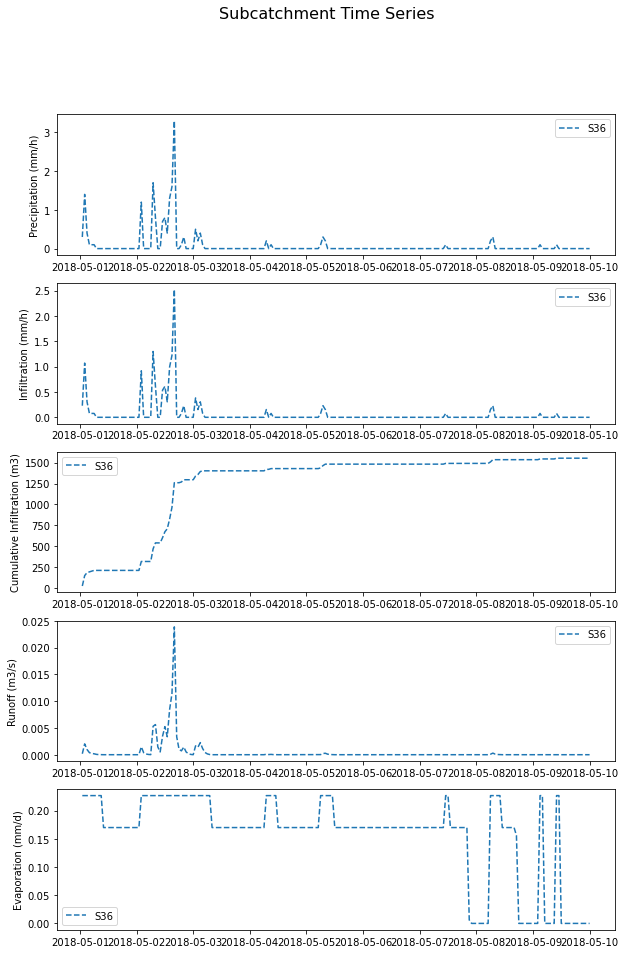

In [398]:
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,1, figsize=(10,15))
ax1.plot(S_SWMM_TS[i].Time,S_SWMM_TS[i]["Precipitation (mm/h)"], label=S_name,linestyle="--" )
ax1.set_ylabel("Precipitation (mm/h)")
ax1.legend()
ax2.plot(S_SWMM_TS[i].Time, S_SWMM_TS[i]["Infiltration (mm/h)"], label=S_name,linestyle="--"  )
ax2.set_ylabel("Infiltration (mm/h)")
ax2.legend()
ax3.plot(S_SWMM_TS[i].Time,S_SWMM_TS[i]["Cumulative Infiltration (m3)"], label=S_name,linestyle="--" )
ax3.set_ylabel("Cumulative Infiltration (m3)")
ax3.legend()
ax4.plot(S_SWMM_TS[i].Time,S_SWMM_TS[i]["Runoff (m3/s)"], label=S_name,linestyle="--" )
ax4.legend()
ax4.set_ylabel("Runoff (m3/s)")
ax5.plot(S_SWMM_TS[i].Time,S_SWMM_TS[i]["Evaporation (mm/d)"], label=S_name,linestyle="--" )
ax5.legend()
ax5.set_ylabel("Evaporation (mm/d)")
f.suptitle("Subcatchment Time Series",fontsize=16)
plt.show()

In [399]:
S_name="S25"
i=S_names_list.index(S_name)

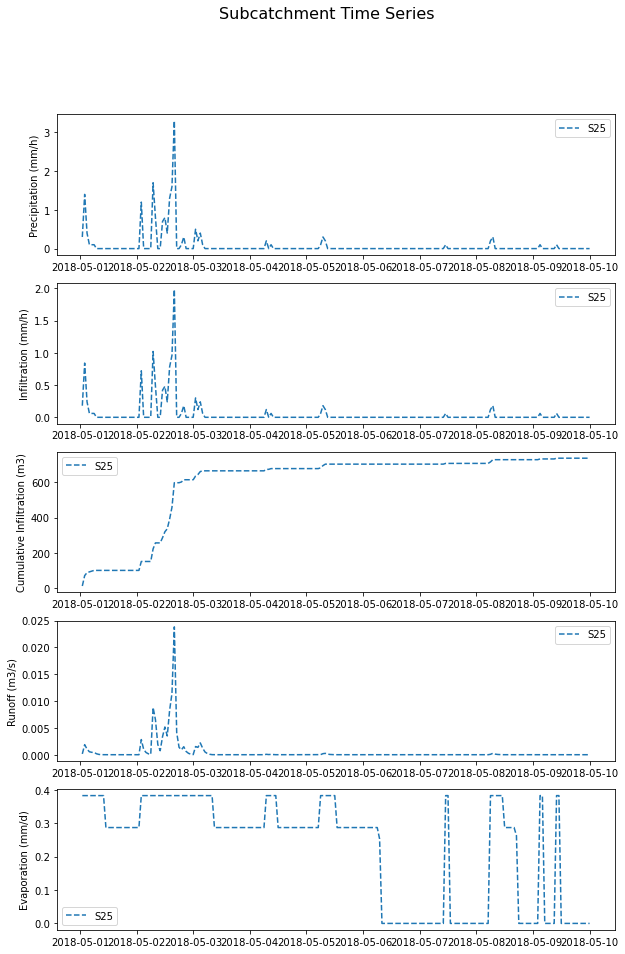

In [400]:
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,1, figsize=(10,15))
ax1.plot(S_SWMM_TS[i].Time,S_SWMM_TS[i]["Precipitation (mm/h)"], label=S_name,linestyle="--" )
ax1.set_ylabel("Precipitation (mm/h)")
ax1.legend()
ax2.plot(S_SWMM_TS[i].Time, S_SWMM_TS[i]["Infiltration (mm/h)"], label=S_name,linestyle="--"  )
ax2.set_ylabel("Infiltration (mm/h)")
ax2.legend()
ax3.plot(S_SWMM_TS[i].Time,S_SWMM_TS[i]["Cumulative Infiltration (m3)"], label=S_name,linestyle="--" )
ax3.set_ylabel("Cumulative Infiltration (m3)")
ax3.legend()
ax4.plot(S_SWMM_TS[i].Time,S_SWMM_TS[i]["Runoff (m3/s)"], label=S_name,linestyle="--" )
ax4.legend()
ax4.set_ylabel("Runoff (m3/s)")
ax5.plot(S_SWMM_TS[i].Time,S_SWMM_TS[i]["Evaporation (mm/d)"], label=S_name,linestyle="--" )
ax5.legend()
ax5.set_ylabel("Evaporation (mm/d)")
f.suptitle("Subcatchment Time Series",fontsize=16)
plt.show()

### Storage Units:

In [403]:
WSU_name="W3"
i=WSU_names_list.index(WSU_name)

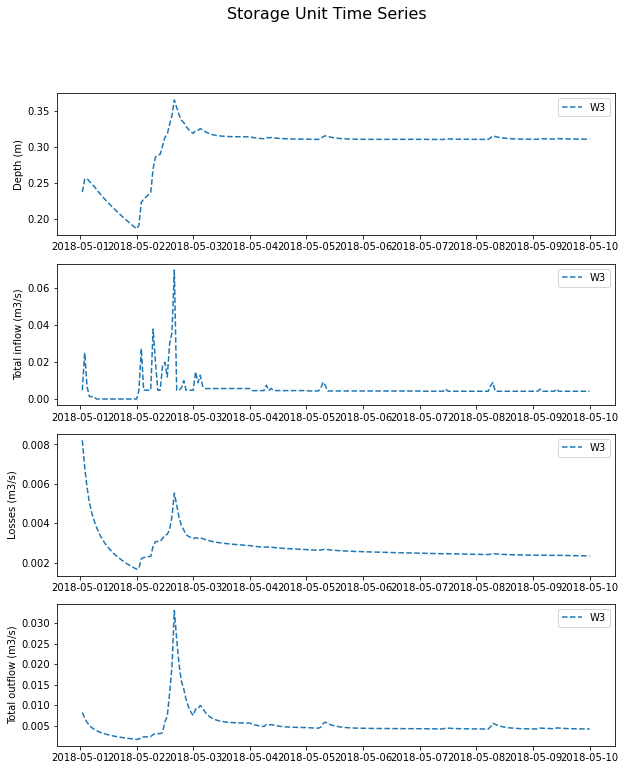

In [404]:
f, (ax1, ax2, ax3, ax5) = plt.subplots(4,1, figsize=(10,12))
ax1.plot(WSU_SWMM_TS[i].Time,WSU_SWMM_TS[i]["Depth (m)"], label=WSU_name,linestyle="--" )
ax1.legend()
ax1.set_ylabel("Depth (m)")
ax2.plot(WSU_SWMM_TS[i].Time,WSU_SWMM_TS[i]["Total inflow (m3/s)"],label=WSU_name,linestyle="--" )
ax2.legend()
ax2.set_ylabel("Total inflow (m3/s)")
ax3.plot(WSU_SWMM_TS[i].Time,WSU_SWMM_TS[i]["Losses (m3/s)"],label=WSU_name,linestyle="--")
ax3.legend()
ax3.set_ylabel("Losses (m3/s)")
#ax4.plot(SU_SWMM_TS[i].index,SU_SWMM_TS[i]["Cumulative Exfiltration Loss (m3)"],label=SU_name,linestyle="--"  )
#ax4.legend()
#ax4.set_ylabel("Cumulative Exfiltration Loss (m3)")
ax5.plot(WSU_SWMM_TS[i].Time,WSU_SWMM_TS[i]["Total outflow (m3/s)"],label=WSU_name,linestyle="--" )
ax5.legend()
ax5.set_ylabel("Total outflow (m3/s)")
f.suptitle("Storage Unit Time Series",fontsize=16)
plt.show()

## Nodes:

In [405]:
for i in J_names_list:
    a= pd.DataFrame()
    a["Time"]=""
    a["Depth (m)"]=""
    a["Head (m)"]=""
    a["Flooding (m3/s)"]=""
    a["Lateral inflow (m3/s)"]=""
    a["Total inflow (m3/s)"]=""
    a["Total outflow (m3/s)"]=""
    J_SWMM_TS.append(a)

In [406]:
J_name="TS7"
i=J_names_list.index(J_name)

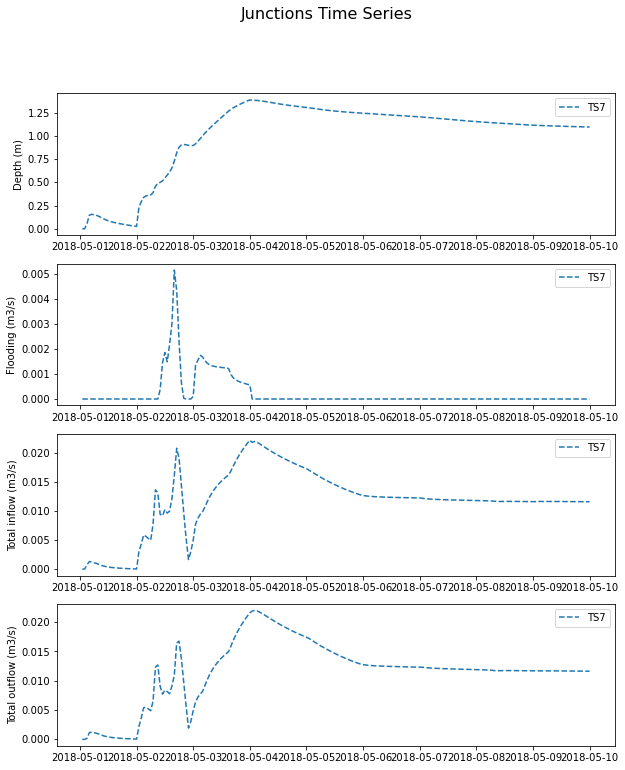

In [407]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(10,12))
ax1.plot(J_SWMM_TS[i].Time,J_SWMM_TS[i]["Depth (m)"], label=J_name,linestyle="--" )
ax1.legend()
ax1.set_ylabel("Depth (m)")
ax2.plot(J_SWMM_TS[i].Time,J_SWMM_TS[i]["Flooding (m3/s)"],label=J_name,linestyle="--" )
ax2.legend()
ax2.set_ylabel("Flooding (m3/s)")
ax3.plot(J_SWMM_TS[i].Time,J_SWMM_TS[i]["Total inflow (m3/s)"],label=J_name,linestyle="--")
ax3.legend()
ax3.set_ylabel("Total inflow (m3/s)")
ax4.plot(J_SWMM_TS[i].Time,J_SWMM_TS[i]["Total outflow (m3/s)"],label=J_name,linestyle="--" )
ax4.legend()
ax4.set_ylabel("Total outflow (m3/s)")
f.suptitle("Junctions Time Series",fontsize=16)
plt.show()

## MODFLOW Results

### DRN_rate

<AxesSubplot:>

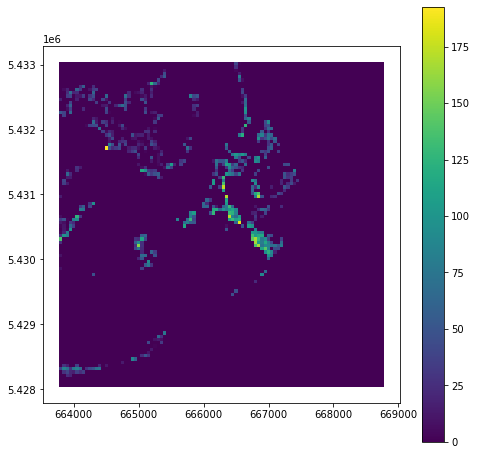

In [418]:
dia=1
fig, ax1 = plt.subplots(1, 1 ,figsize=(8,8))
TS_gdf[dia].plot(column='DRN_rate', ax=ax1, legend=True)

revisar el nodo max!!!

### RCH_rate

<AxesSubplot:>

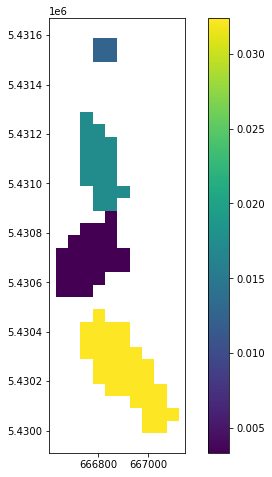

In [409]:
fig, ax1 = plt.subplots(1, 1 ,figsize=(8,8))
TS_gdf[dia].plot(column='RCH_WSU', ax=ax1, legend=True)

<AxesSubplot:>

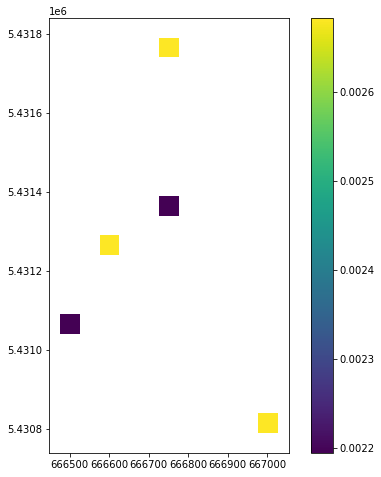

In [410]:
fig, ax1 = plt.subplots(1, 1 ,figsize=(8,8))
TS_gdf[dia].plot(column='RCH_FSU', ax=ax1, legend=True)

<AxesSubplot:>

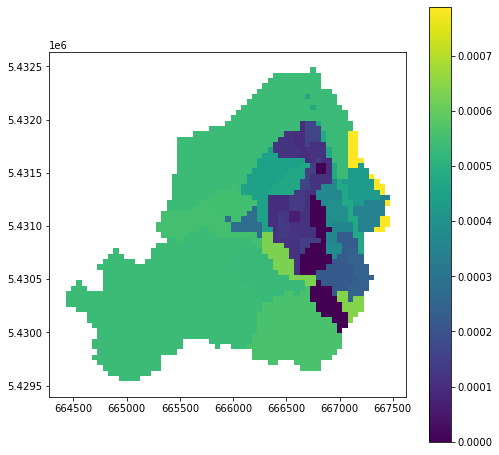

In [411]:
fig, ax1 = plt.subplots(1, 1 ,figsize=(8,8))
TS_gdf[dia].plot(column='RCH_S', ax=ax1, legend=True)

<AxesSubplot:>

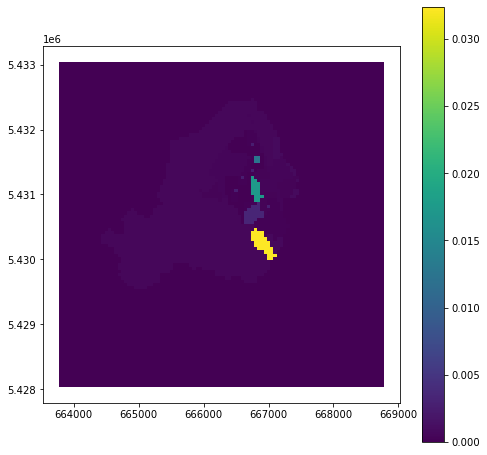

In [412]:
fig, ax1 = plt.subplots(1, 1 ,figsize=(8,8))
TS_gdf[dia].plot(column='RCH', ax=ax1, legend=True)

## Coupling Results

In [413]:
S_rch_df=pd.DataFrame()
for s in S_names_list:
    S_rch=[]
    for i in range(int(len(TS_gdf))):
        rch=TS_gdf[i].groupby("S").sum()["RCH"]
        S_rch.append(rch[s]*x_resolution*y_resolution)
    S_rch_df[s]=S_rch

Text(0.5, 0, 'Días')

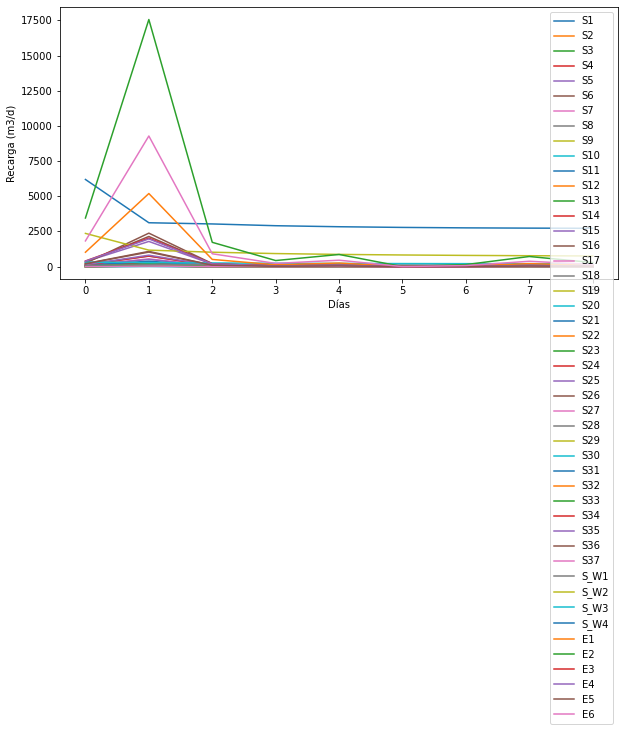

In [414]:
S_rch_df.plot(figsize=(10,5))
plt.ylabel("Recarga (m3/d)")
plt.xlabel("Días")

In [415]:
S_drn_df=pd.DataFrame()
for s in S_names_list:
    S_drn=[]
    for i in range(int(len(TS_gdf))):
        drn=TS_gdf[i].groupby("S").sum()["DRN_rate"]
        S_drn.append(drn[s])
    S_drn_df[s]=S_drn

Text(0.5, 0, 'Días')

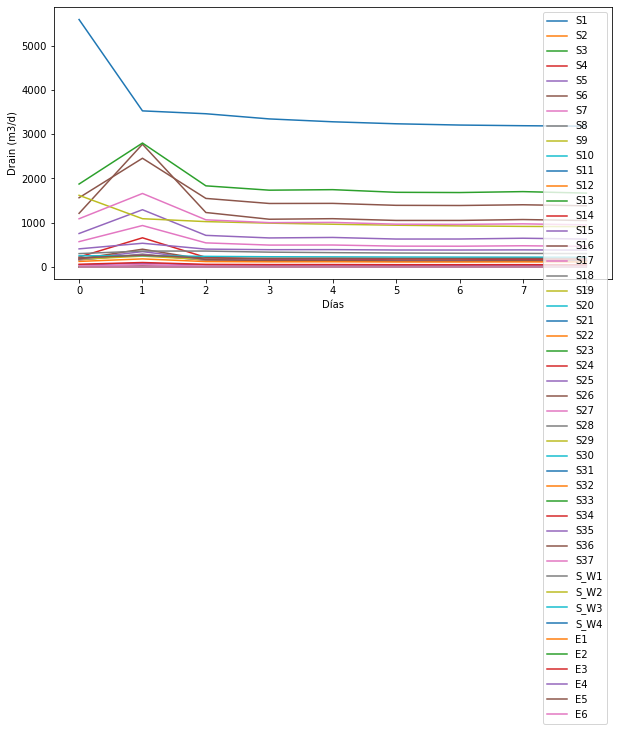

In [416]:
S_drn_df.plot(figsize=(10,5))
plt.ylabel("Drain (m3/d)")
plt.xlabel("Días")

## Frecuency Analysis

# PRUEBAS